#### **PREDICCIÓN DEL RENDIMIENTO A MEDIO PLAZO PARA SELECCIÓN DE ACTIVOS FINANCIEROS CON MÉTODOS CLÁSICOS Y LSTM**


Este notebook tiene como objetivo desarrollar un sistema de análisis y predicción del rendimiento de acciones a medio y largo plazo, mediante técnicas de aprendizaje automático.
Se parte de un conjunto de datos históricos de mercado con múltiples variables técnicas y temporales, sobre el que se realiza un análisis exploratorio, limpieza y generación de características relevantes.
Posteriormente, se aplican modelos como Naive Bayes, SVM y LSTM para clasificar activos con alta probabilidad de obtener una rentabilidad superior al +10% en los próximos meses, con el fin de construir una cartera de inversión inteligente basada en decisiones automatizadas.

#### **1.LIBRERÍAS**

In [1]:
!pip install pandas adlfs pyarrow

#### **2.IMPORTS**

In [2]:
# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
import random
import plotly.express as px
import joblib
from datetime import timedelta
from typing import List, Tuple, Dict,Optional

# Azure
from adlfs import AzureBlobFileSystem

# Models
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler,LabelEncoder
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc ,  precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

2025-05-31 17:31:12.861816: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748712673.731212    3347 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748712674.004316    3347 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748712676.407787    3347 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748712676.407838    3347 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748712676.407840    3347 computation_placer.cc:177] computation placer alr

#### **3.FUNCIONES**

In [3]:
def extract_basic_info(df: pd.DataFrame,are_all_symbols: bool=True)-> None:
    """
    Prints basic information like the number of null values, the shape of the dataframe or the date ranges.
    Args:
        - df (pd.DataFrame): input dataframe
        - are_all_symbols (bool): False to print the variables 'symbol' and 'date'
    Returns:
        - None
    """
    # Basic dataset info
    print("Shape:", df.shape)
    if are_all_symbols:
        print("Symbols:", df['symbol'].nunique())
        print("Date range:", df['date'].min(), "→", df['date'].max())

    # Calculate and show sorted null counts
    null_counts = df.isnull().sum()
    null_counts_sorted = null_counts[null_counts > 0].sort_values(ascending=False)

    print("\nMissing values (sorted):")
    print(null_counts_sorted)

    # Extract ordered list of columns with missing values
    cols_with_nans_sorted = null_counts_sorted.index.tolist()
    print("\nColumns with missing values (sorted):")
    print(cols_with_nans_sorted)
    return None

In [4]:

def load_data_from_dl(account_name: str,container_name: str,relative_path: str,access_key: str)->pd.DataFrame:
    """
    Loads all Parquet files from an Azure Blob Storage path into a single DataFrame.
    Args:
        - account_name (str): Azure Storage account name.
        - container_name (str): Name of the container.
        - relative_path (str): Path inside the container to search for .parquet files.
        - access_key (str): Storage account access key.
    Returns:
        - df (pd.DataFrame): Combined DataFrame from all found Parquet files.
    Raises:
        - ValueError: If no Parquet files are found in the path.
    """
    abfs = AzureBlobFileSystem(account_name=account_name, account_key=access_key)
    

    all_files = abfs.glob(f"{container_name}/{relative_path}/*.parquet")
    print(f"folder: {all_files}")

    if not all_files:
        raise ValueError("Not found .parquet files")

    dfs = []
    for f in all_files:
        print(f"Reading files: {f}")
        with abfs.open(f, "rb") as fp:
            dfs.append(pd.read_parquet(fp))

    df = pd.concat(dfs, ignore_index=True)
    print(df.head())
    return df


In [5]:
def plot_target_distribution(df: pd.DataFrame, target_column: str, label: str="+10%")->None:
    """
    Plots the class distribution of a binary target column.
    Args:
        - df (pd.DataFrame): DataFrame containing the target column
        - target_column (str): Name of the binary column to analyze (e.g., 'target_3m')
        - label (str): Description of the target condition to include in the plot title
    Returns:
        - None
    """
    # Count the values (0 = No, 1 = Yes), sorted by class
    counts = df[target_column].value_counts().sort_index()
    
    # Create the bar plot
    plt.bar(["No", "Yes"], counts.values, color=["red", "green"])
    plt.title(f"Class distribution: {label} in {target_column}")
    plt.ylabel("Number of records")
    plt.grid(True, axis="y")
    plt.tight_layout()
    plt.show()
    return None

In [6]:
def plot_close_price(df: pd.DataFrame, symbol:str)->None:
    """
    Plots the close_v price over time for a given stock symbol.
    Args:
       - df (pd.DataFrame): DataFrame containing at least 'symbol', 'date', and 'close_v'
       - symbol (str): Stock symbol to filter and plot
    Returns:
       - None
    """
    data = df[df["symbol"] == symbol].sort_values("date")

    plt.figure(figsize=(12, 4))
    plt.plot(data["date"], data["close_v"])
    plt.title(f"close_v - {symbol}")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return None

In [7]:
def plot_correlation_heatmap(df:pd.DataFrame, columns: List[str] )-> None:
    """
    Plots a correlation heatmap using matplotlib for the given columns.
    Args:
       - df (pd.DataFrame): DataFrame containing the data
       - columns (list): List of column names to include in the correlation matrix
    Returns:
       - None
    """
    corr = df[columns].corr()

    fig, ax = plt.subplots(figsize=(10, 8))
    cax = ax.matshow(corr, cmap="coolwarm")
    fig.colorbar(cax)

    ax.set_xticks(np.arange(len(columns)))
    ax.set_yticks(np.arange(len(columns)))
    ax.set_xticklabels(columns, rotation=45, ha="left")
    ax.set_yticklabels(columns)

    plt.title("Correlation Matrix", pad=20)
    plt.tight_layout()
    plt.show()
    return None

In [8]:
def prepare_data(df, targets, scaler_type='standard', drop_cols=['date', 'symbol']):
    """
    Prepares data for machine learning models by:
    - Encoding categorical columns
    - Scaling numerical features
    - Keeping target columns unmodified

    Args:
        - df (pd.DataFrame): The full DataFrame including features and targets.
        - targets (list): List of column names that are target variables.
        - scaler_type (str): default='standard'. Type of scaler to use: 'standard' (StandardScaler) or 'minmax' (MinMaxScaler).
        - drop_cols (list): List of non-feature columns to drop (e.g., identifiers).

    Returns:
        - df_scaled (pd.DataFrame): DataFrame with scaled features and original targets.
        - scaler(object) : fitted scaler object
    """
    df_clean = df.copy()

    # Drop identifiers (symbol, date, etc.)
    df_clean = df_clean.drop(columns=drop_cols, errors='ignore')

    # Encode categorical columns
    for col in df_clean.select_dtypes(include=['category', 'object']).columns:
        df_clean[col] = LabelEncoder().fit_transform(df_clean[col])

    # Separate features and targets
    feature_cols = [col for col in df_clean.columns if col not in targets]
    X = df_clean[feature_cols]
    y = df_clean[targets]

    # Choose and fit scaler
    scaler = StandardScaler() if scaler_type == 'standard' else MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    df_scaled = pd.DataFrame(X_scaled, columns=feature_cols, index=X.index)

    # Re-add targetstypes
    df_scaled = pd.concat([df_scaled, y], axis=1)

    return df_scaled, scaler

In [9]:
def model_evaluation(
    y_test: pd.Series,
    y_pred: pd.Series,
    y_prob: pd.Series
) -> Tuple[float, float, float]:
    """
    Evaluates the classification model and plots the metrics
    Args:
        - y_test (pd.Series): True target vals
        - y_pred (pd.Series): Predicted class vals
        - y_prov (pd.Series): Predicted probss for clas 1
    Returns:
        - Tuple[float, float, float]: Accuracy, F1 Score, and ROC AUC.
    """
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)
    cm = confusion_matrix(y_test, y_pred)
    precission = precision_score(y_test, y_pred)
    recall= recall_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc:.4f}")
    print(f"Confusion Matrix:\n {cm}")
    print(f"Precision: {precission:.4f}")
    print(f"Recall: {recall:.4f}")    

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(5, 4))
    cax = ax.matshow(cm, cmap='Blues')
    fig.colorbar(cax)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['No', 'Yes'])
    ax.set_yticklabels(['No', 'Yes'])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return acc, f1, roc,cm,precission,recall



In [10]:
def apply_pca(
    df: pd.DataFrame,
    targets: List[str],
    variance_threshold: float = 0.95
) -> Tuple[pd.DataFrame, PCA]:
    """
    Applies PCA after imputing missing values using the mean strategy.

    Args:
        df (pd.DataFrame): DataFrame with features and targets.
        targets (List[str]): List of target column names.
        variance_threshold (float): Minimum cumulative variance to preserve.

    Returns:
        Tuple[pd.DataFrame, PCA]: PCA-transformed DataFrame with targets and the fitted PCA object.
    """
    feature_cols = [col for col in df.columns if col not in targets]
    X = df[feature_cols]
    y = df[targets]

    # Impute missing values
    X_imputed = SimpleImputer(strategy='mean').fit_transform(X)

    # Apply PCA
    pca = PCA(n_components=variance_threshold)
    X_pca = pca.fit_transform(X_imputed)

    # Create DataFrame with PCA components
    pca_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
    df_pca = pd.DataFrame(X_pca, columns=pca_columns, index=df.index)
    df_pca = pd.concat([df_pca, y], axis=1)

    # Plot cumulative explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
    plt.axhline(y=variance_threshold, color='r', linestyle='--', label=f'{variance_threshold:.0%} threshold')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance by PCA Components')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return df_pca, pca

#### **4.DATA PREPARATION**

##### **4.1 CARGA DE FICHEROS**

In [11]:
#Loads yaml file with  DL access configs
with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)

account_name = config['storage']['storage_account_name']
container_name = config['storage']['container_name']
relative_path = config['storage']['relative_path']
access_key = config['storage']['access_key']

In [12]:
df=load_data_from_dl(account_name,container_name,relative_path,access_key)

folder: ['smart-wallet-dl/smart_wallet/stock_data_parquet/part-00000-tid-6797290562885514763-299022fb-16e9-469c-9196-d9d7f930f68e-120-1-c000.snappy.parquet']
Reading files: smart-wallet-dl/smart_wallet/stock_data_parquet/part-00000-tid-6797290562885514763-299022fb-16e9-469c-9196-d9d7f930f68e-120-1-c000.snappy.parquet
         date symbol     open_v       high        low    close_v    volume  \
0  2011-02-11    AAT  12.882077  13.052942  12.827156  13.052942  175600.0   
1  2011-02-14    AAT  12.943103  13.150583  12.906489  13.028537  154900.0   
2  2011-02-15    AAT  12.906490  13.059049  12.875979  12.985822  183800.0   
3  2011-02-16    AAT  13.052948  13.052948  12.924799  12.998027   56200.0   
4  2011-02-17    AAT  12.998025  13.358064  12.998025  13.144483  146600.0   

   dividends  stock_splits  capital_gains  ...  candle_color  momentum_10  \
0        0.0           0.0            NaN  ...         green     0.054915   
1        0.0           0.0            NaN  ...         gre

In [16]:
print("Types summary \n:")
print(df.dtypes.value_counts())

Types summary 
:
float64    50
object      3
int32       2
dtype: int64


In [17]:
object_cols = df.select_dtypes(include="object").columns.tolist()
print("Object type columns:", object_cols)

Object type columns: ['date', 'symbol', 'candle_color']


In [13]:
df["date"] = pd.to_datetime(df["date"])
df["symbol"] = df["symbol"].astype("category")
df["candle_color"] = df["candle_color"].astype("category")

In [19]:
df.shape

(11482274, 55)

In [20]:
df['symbol'].nunique()

2728

A la hora de entrenar el algoritmo SVM o LSTM con un 80% de datos de entrenamiento y 20% de datos de test, con los recursos disponibles el entrenamiento se demora demasiado. A continuación comprobamos que el máximo de sesiones son 6494 y que nuestro dataset tiene 2724 empresas únicas. Vamos a tener que tomar una decisión sobre qué accioens mantener.  Si limitamos el rango temporal, no contabilizamos posibles "cisnes negros", eventos que causaron caídas abruptas en las bolsas. Si limitamos por histórico a las empresas que lleven más de 10 años en bolsa, dejamos fuera empresas de reciente creación que pueden ser prometedoras. Nuestro objetivo es poder identificar acciones prometedoras para poder maximizar nuestra rentabilidad como inversores. 

In [21]:
df_symbol_counts = df.groupby("symbol").size().reset_index(name="n_rows").sort_values('n_rows',ascending=False)
df_symbol_counts.head(10)

,symbol,n_rows
1525,MBK.WA,6514
491,CDR.WA,6513
1362,KGH.WA,6513
1885,PEO.WA,6513
1917,PKN.WA,6513
315,BCP.LS,6509
787,EDP.LS,6509
1330,JMT.LS,6508
4,AALB.AS,6507
2160,SBMO.AS,6506


<Axes: >

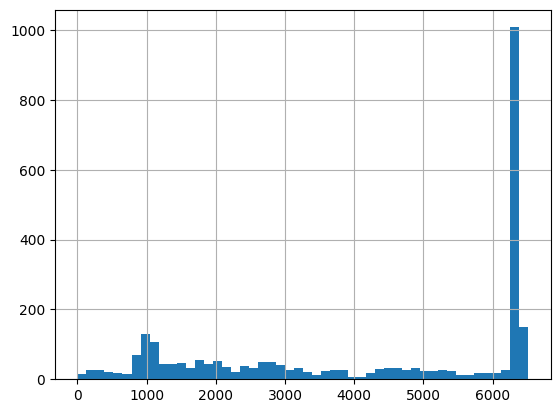

In [22]:
df_symbol_counts = df.groupby("symbol").size().reset_index(name="n_rows")
df_symbol_counts["n_rows"].hist(bins=50)

In [23]:
for threshold in [1000, 1500, 2000, 3000, 4000,5000,6000]:
    n = (df_symbol_counts["n_rows"] >= threshold).sum()
    print(f"At least contains {threshold} sessions: {n} symbols")

At least contains 1000 sessions: 2443 symbols
At least contains 1500 sessions: 2170 symbols
At least contains 2000 sessions: 2001 symbols
At least contains 3000 sessions: 1711 symbols
At least contains 4000 sessions: 1541 symbols
At least contains 5000 sessions: 1357 symbols
At least contains 6000 sessions: 1198 symbols


##### **4.2 CREACIÓN DE LA VARIABLE TARGET**

##### **4.2 CREACIÓN DE LA VARIABLE TARGET**

El propósito de este TFM es tratar de construir una cartera inteligente a medio/largo plazo basada en el comportamiento técnico y estadístico de los activos medidos. Para ello se definirán 3 ventanas temporales distintas que representarán nuestros objetivos de predicción: target_3m, target_6m y target_1y.

En horizontes cortos, como los 3 meses, la evolución del precio puede estar dominada por factores externos, eventos puntuales o ruido de mercado, lo que dificulta que un modelo técnico pueda capturar valores consistentes. A este plazo, la volatilidad tiende a ser más elevada y menso explicable a través del análisis técnico tradicional.

A los 6 meses, los indicadores técnicos y de momentum suelen tener mayor capacidad para anticipar movimientos sostenidos, ya que se reducen los efectos de las oscilaciones a corto plazo. 

Finalmente, a 1 año vista, el enfoque es un poco más estructural. El modelo busca detectar activos con inercia positiva prolongada y fundamentos técnicos más sólidos, que sean capaces de sostener su crecimiento.

Para evitar errores metodológicos, se va a evitar utilizar como variables de entrada aquellas que están directamente impactadas en la construcción del propio objetivo. Es decir, por ejemplo, no se utilizará ret_past_1y para predecir target_1y. 

Por lo tanto, cuando construyamos los algoritmos, se establecerán mecanismos de control para evitar fugas de información y asegurar que el aprendizaje se base exclusivamente en datos disponibles en el momento de la predicción.


In [14]:
df["target_3m"] = (df["ret_next_3m"] > 0.10).astype(int)
df["target_6m"] = (df["ret_next_6m"] > 0.10).astype(int)
df["target_1y"] = (df["ret_next_1y"] > 0.10).astype(int)

La distribución de clases muestra un ligero desbalanceo.

In [19]:
df['target_3m'].value_counts(normalize=True)

0    0.695479
1    0.304521
Name: target_3m, dtype: float64

In [16]:
df['target_6m'].value_counts(normalize=True)

0    0.610098
1    0.389902
Name: target_6m, dtype: float64

In [17]:
df['target_1y'].value_counts(normalize=True)

0    0.54114
1    0.45886
Name: target_1y, dtype: float64

In [18]:
df.shape

(11482274, 56)

##### **4.3 ANÁLISIS DE DATOS EXPLORATORIO**

In [20]:
print(f"max date: {min(df.date)}")
print(f"min date: {max(df.date)}")
print(df.shape)

max date: 2000-01-31 00:00:00
min date: 2025-05-16 00:00:00
(11482274, 56)


In [21]:
df.describe()

,open_v,high,low,close_v,volume,dividends,stock_splits,capital_gains,prev_close,prev_volume,...,var_95,price_lead_3m,price_lead_6m,price_lead_1y,ret_next_3m,ret_next_6m,ret_next_1y,target_3m,target_6m,target_1y
count,1.148155e+07,1.148155e+07,1.148155e+07,1.148155e+07,1.148155e+07,1.145228e+07,1.145228e+07,7348.0,1.148157e+07,1.148157e+07,...,1.148227e+07,1.130989e+07,1.113865e+07,1.079844e+07,1.130417e+07,1.113299e+07,1.079290e+07,1.148227e+07,1.148227e+07,1.148227e+07
mean,1.873613e+06,1.962834e+06,1.763391e+06,1.872133e+06,6.980544e+06,1.754005e-02,2.882228e-04,0.0,1.877734e+06,6.980277e+06,...,-3.504564e-02,1.594010e+06,1.051892e+06,5.383887e+05,4.915334e-02,8.560003e-02,1.831868e-01,3.045207e-01,3.899022e-01,4.588601e-01
std,3.371690e+08,3.511776e+08,3.168303e+08,3.364750e+08,1.255615e+08,5.918824e+00,3.408135e-02,0.0,3.370065e+08,1.255593e+08,...,2.331396e-02,3.123051e+08,1.979356e+08,1.032327e+08,9.869676e+00,1.199445e+00,3.062883e+00,4.602041e-01,4.877279e-01,4.983047e-01
min,-7.560517e+06,-7.748446e+06,-7.517148e+06,-7.653034e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.0,-7.653034e+06,0.000000e+00,...,-6.666666e-01,-7.653034e+06,-7.653034e+06,-7.350904e+06,-1.001415e+01,-9.381862e+00,-2.293004e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.416559e+00,9.590000e+00,9.237314e+00,9.415393e+00,7.830000e+04,0.000000e+00,0.000000e+00,0.0,9.414204e+00,7.820000e+04,...,-4.272256e-02,9.470832e+00,9.532314e+00,9.680000e+00,-8.022194e-02,-1.027382e-01,-1.300511e-01,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.027668e+01,2.060302e+01,1.994536e+01,2.027544e+01,3.761000e+05,0.000000e+00,0.000000e+00,0.0,2.027094e+01,3.759000e+05,...,-2.867384e-02,2.043045e+01,2.059594e+01,2.094144e+01,2.389442e-02,4.670116e-02,9.046793e-02,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.770042e+01,4.839059e+01,4.698257e+01,4.769579e+01,1.562100e+06,0.000000e+00,0.000000e+00,0.0,4.768000e+01,1.561800e+06,...,-2.027472e-02,4.812000e+01,4.857846e+01,4.950203e+01,1.299001e-01,2.012249e-01,3.276056e-01,1.000000e+00,1.000000e+00,1.000000e+00
max,1.356750e+11,1.370250e+11,1.275750e+11,1.363500e+11,1.145623e+10,9.403261e+03,5.000000e+01,0.0,1.363500e+11,1.145623e+10,...,5.048864e-03,1.363500e+11,1.107000e+11,3.577500e+10,1.370900e+04,1.819963e+03,3.589000e+03,1.000000e+00,1.000000e+00,1.000000e+00


##### 4.3.1 Análisis de valores nulos

Antes de aplicar los distintos modelos de predicción —tanto algoritmos clásicos como Naive Bayes y SVM, como redes neuronales recurrentes tipo LSTM— es necesario realizar un análisis exploratorio común que permita evaluar la calidad y completitud de los datos. Este paso es esencial para garantizar la robustez del flujo de trabajo y evitar sesgos derivados de valores faltantes.

Nuestro dataset contiene variables técnicas derivadas como rsi_14, roc_10, log_return, entre otras, que forman la base de las predicciones. Estas columnas son generadas mediante cálculos acumulativos o ventanas móviles, por lo que es habitual que presenten valores nulos en los primeros registros de cada serie temporal.

Dado que los modelos clásicos como Naive Bayes o SVM no están diseñados para gestionar valores nulos, es imprescindible que el conjunto de datos esté completamente limpio antes del entrenamiento. Asimismo, aunque las redes LSTM pueden tolerar cierto preprocesado específico, también requieren secuencias completas y consistentes en sus entradas.

Por tanto, el análisis exploratorio debe centrarse inicialmente en:

- Identificar la proporción y distribución de valores nulos.
- Evaluar el impacto de estos nulos sobre las variables clave.
- Decidir estrategias de imputación o eliminación según el modelo a aplicar.

Una vez depurado el conjunto de datos, será posible construir los datasets específicos para cada modelo de clasificación.


In [22]:
extract_basic_info(df)

Shape: (11482274, 56)
Symbols: 2728
Date range: 2000-01-31 00:00:00 → 2025-05-16 00:00:00

Missing values (sorted):
capital_gains          11474926
ret_next_1y              689369
price_lead_1y            683838
ret_next_6m              349285
price_lead_6m            343628
ret_next_3m              178100
price_lead_3m            172380
dividends                 29989
stock_splits              29989
log_return                 7073
gap_open                   1289
delta                      1289
close_change_pct           1289
momentum_10                1077
intraday_volatility         722
tr_1                        722
low                         722
close_v                     722
lower_wick                  722
upper_wick                  722
candle_body                 722
price_range                 722
open_v                      722
high                        722
daily_return                722
volume                      721
prev_close                  708
prev_volume         

In [23]:
print(df.columns)

Index(['date', 'symbol', 'open_v', 'high', 'low', 'close_v', 'volume',
       'dividends', 'stock_splits', 'capital_gains', 'prev_close',
       'prev_volume', 'daily_return', 'close_change_pct',
       'intraday_volatility', 'price_range', 'gap_open', 'log_return',
       'volume_change_pct', 'is_dividend_day', 'is_stock_split', 'sma_5',
       'sma_20', 'delta', 'gain', 'loss', 'rsi_14', 'bollinger_upper',
       'bollinger_lower', 'rel_volume', 'ema_12', 'ema_26', 'macd_line',
       'macd_signal', 'macd_histogram', 'tr_1', 'tr_2', 'tr_3', 'true_range',
       'atr_14', 'candle_body', 'upper_wick', 'lower_wick', 'candle_color',
       'momentum_10', 'roc_10', 'var_95', 'price_lead_3m', 'price_lead_6m',
       'price_lead_1y', 'ret_next_3m', 'ret_next_6m', 'ret_next_1y',
       'target_3m', 'target_6m', 'target_1y'],
      dtype='object')


A continuación vamos a realizar un análisis de las columnas que contienen valores nulos. 

- `capital_gains`: Tiene la mayor cantidad de valores nulos. Más del 99% de los registros tienen valores NaN en dicha columna. Es una variable irrelevante en la mayoría de los activos, ya que sólo aparece en casos raros de dividendos especiales o eventos contables muy específicos. Como introduce ruido, imputar valores o eliminar filas  complicaría el modelo.  Vamos a considerarla como una variable muerta y la eliminaremos del dataset.

In [24]:
df.drop(columns=['capital_gains'], inplace=True)

- ret_next_[i][z]: Estas características miden las rentabilidades acumuladas desde el día actual hacia adelante (futuro) en distintos horizontes temporales. Concretamente hemos calculado:


```
horizons = {
    "3m": 63,
    "6m": 126,
    "1y": 252  # Rentabilidad en los próximos 3, 6 y 12 meses bursátiles
}

```

Las columnas ret_next_3m, ret_next_6m y ret_next_1y definen las etiquetas objetivo del modelo. Si esos valores son nulos, no podemos saber si la acción cumplió el +10% o no, por tanto no sirven para entrenamiento ni evaluación.

In [25]:
df_future = df[df[["ret_next_3m", "ret_next_6m", "ret_next_1y"]].isnull().any(axis=1)]

df = df.dropna(subset=["ret_next_3m", "ret_next_6m", "ret_next_1y"])

In [26]:
extract_basic_info(df)

Shape: (10792903, 55)
Symbols: 2685
Date range: 2000-01-31 00:00:00 → 2024-05-23 00:00:00

Missing values (sorted):
log_return          12
prev_close           1
close_change_pct     1
gap_open             1
delta                1
momentum_10          1
dtype: int64

Columns with missing values (sorted):
['log_return', 'prev_close', 'close_change_pct', 'gap_open', 'delta', 'momentum_10']


Las columnas con nulos son numéricas y su proporción es insignificante respecto al total de datos (~11 millones de filas). Eliminar esas filas supondría pérdida innecesaria de información.

Imputar con la media mantiene el tamaño del dataset, no introduce sesgos graves y es adecuado cuando los nulos son escasos y no sistemáticos.

In [27]:
numeric_cols = df.select_dtypes(include=["float64", "int64", "int32"]).columns
imputer = SimpleImputer(strategy="mean")
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

/tmp/ipykernel_3347/3982715575.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_cols] = imputer.fit_transform(df[numeric_cols])


In [29]:
extract_basic_info(df)

Shape: (10792903, 55)
Symbols: 2685
Date range: 2000-01-31 00:00:00 → 2024-05-23 00:00:00

Missing values (sorted):
Series([], dtype: int64)

Columns with missing values (sorted):
[]


Las columnas price_lead_3m, price_lead_6m, price_lead_1y son solo valores intermedios usados para calcular ret_next_*, que son las verdaderas variables de interés.

Una vez calculadas las rentabilidades futuras (ret_next_*), los precios futuros brutos dejan de ser necesarios. Mantenerlos solo duplica información, aumenta el tamaño del dataframe y puede introducir riesgo de fugas si se usan por error como input del modelo.

In [35]:
df.drop(columns=["price_lead_3m", "price_lead_6m", "price_lead_1y"], inplace=True)


/tmp/ipykernel_3347/2260233852.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=["price_lead_3m", "price_lead_6m", "price_lead_1y"], inplace=True)


In [36]:
df.shape

(10792903, 52)

##### 4.3.2 Balance de clases

Analizamos cuántas observaciones hay de cada clase (0 y 1). A continuación se muestra un gráfico de barras con los totales, para comprobar si las clases están o no desbalanceadas.  Si hay mucho desbalanceo, tenremos que tratarlo (con acciones como class_weight, oversampling, etc.). 

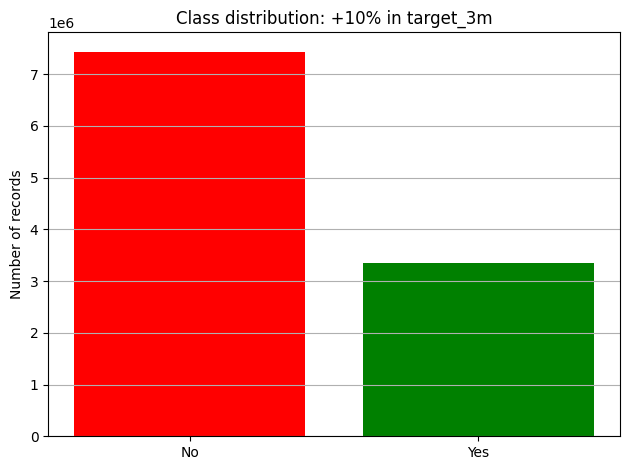

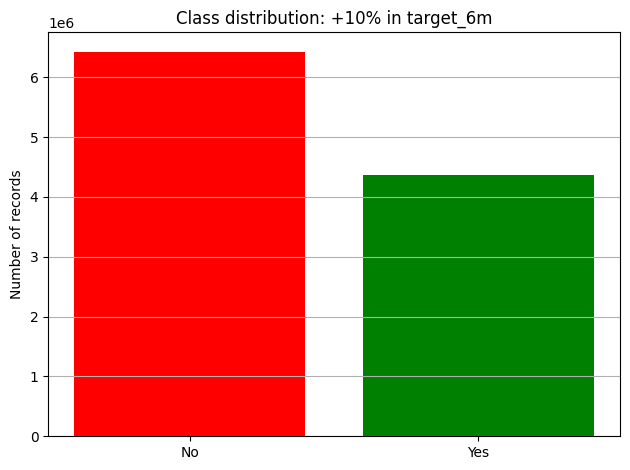

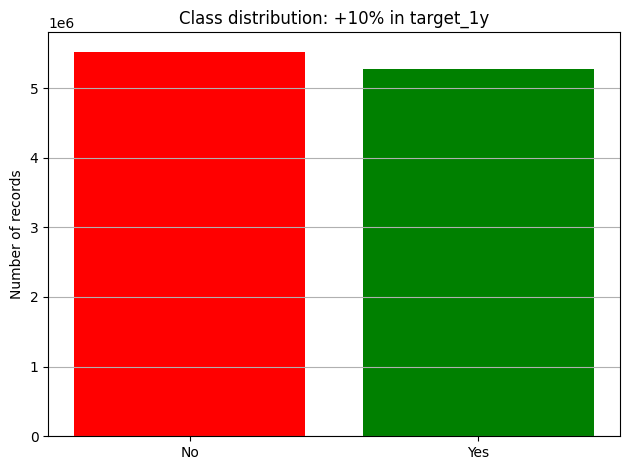

In [32]:
plot_target_distribution(df, "target_3m", "+10%")
plot_target_distribution(df, "target_6m", "+10%")
plot_target_distribution(df, "target_1y", "+10%")

##### 4.3.3 Evolución temporal de una variable para un símbolo

Para terminar de comprobar que nuestros datos son correctos, obtenemos algunos históricos. La forma de las curvas de 3 de las 7 magníficas reflejan perfectamente eventos reales como la subida post-Covid, burbujas, correcciones, etc. Creemos que tenemos un close_v limpio y ajustado a las gráficas reales, lo cual resulta una base sólida para modelar.

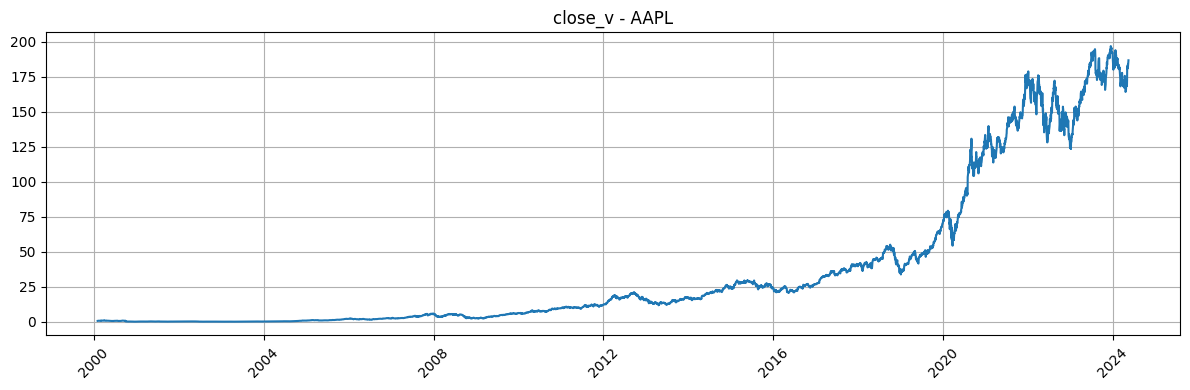

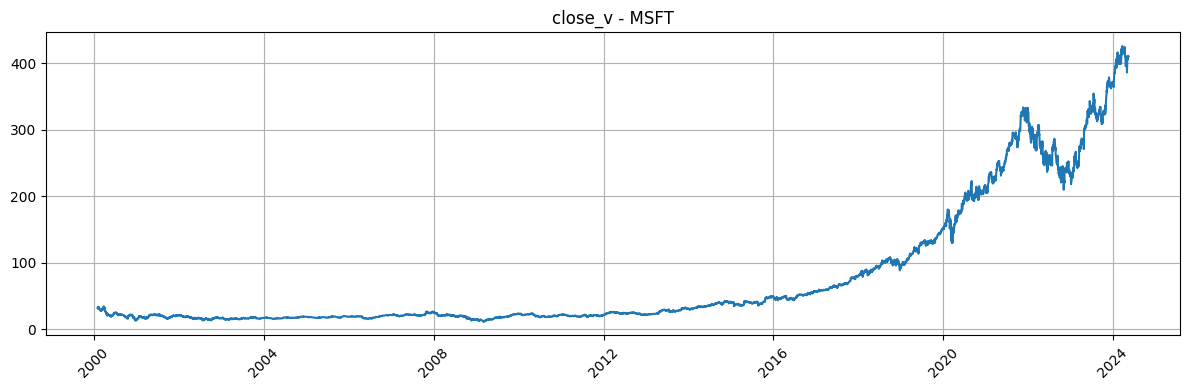

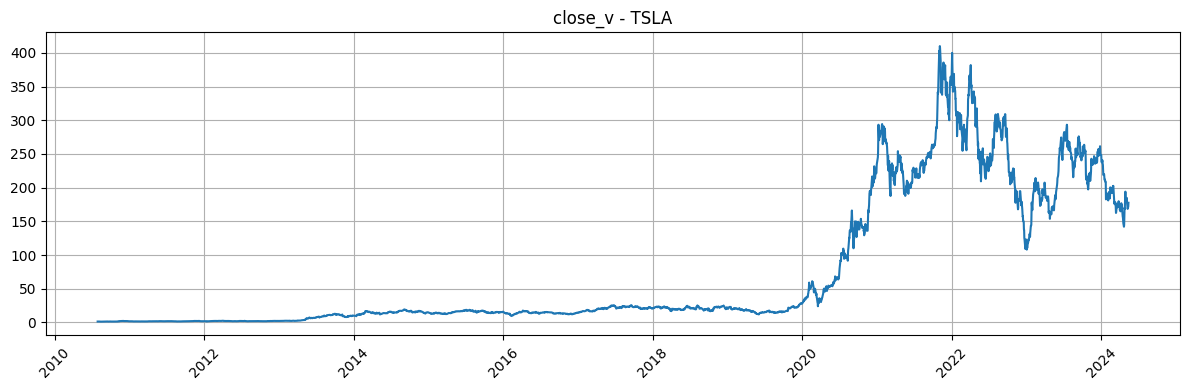

In [33]:
plot_close_price(df, "AAPL")
plot_close_price(df, "MSFT")
plot_close_price(df, "TSLA")

##### 4.3.4 Correlación entre features

El análisis de correlación entre variables permite identificar relaciones lineales entre los distintos indicadores técnicos, financieros y los objetivos de nuestras predicciones.  Su representación mediante heatmaps facilita la visualización de patrones redundantes y orienta la selección de variables relevantes para los modelos. Además, la observación de la correlación entre los indicadores y targets binarios permite realizar una primera evaluación del poder explicativo de cada feature con respecto al comportamiento futuro del activo. 

A continuación dividimos en distintos grupos las variables de nuestro dataset para facilitar su análisis. La correlación se calcula mediante coeficiente de Pearson y se visualiza mediante un Heatmap. Primero calcularemos la correlación intra grupo y, posteriormente, otra sin las variables descartadas.

In [37]:
print(df.columns)

Index(['date', 'symbol', 'open_v', 'high', 'low', 'close_v', 'volume',
       'dividends', 'stock_splits', 'prev_close', 'prev_volume',
       'daily_return', 'close_change_pct', 'intraday_volatility',
       'price_range', 'gap_open', 'log_return', 'volume_change_pct',
       'is_dividend_day', 'is_stock_split', 'sma_5', 'sma_20', 'delta', 'gain',
       'loss', 'rsi_14', 'bollinger_upper', 'bollinger_lower', 'rel_volume',
       'ema_12', 'ema_26', 'macd_line', 'macd_signal', 'macd_histogram',
       'tr_1', 'tr_2', 'tr_3', 'true_range', 'atr_14', 'candle_body',
       'upper_wick', 'lower_wick', 'candle_color', 'momentum_10', 'roc_10',
       'var_95', 'ret_next_3m', 'ret_next_6m', 'ret_next_1y', 'target_3m',
       'target_6m', 'target_1y'],
      dtype='object')


In [38]:
# Identification and basic structure
id_cols = ['date', 'symbol']

# Raw price and volume data
price_cols = ['open_v', 'high', 'low', 'close_v', 'volume']

# Corporate actions and event flags
corporate_actions = ['dividends', 'stock_splits', 'is_dividend_day', 'is_stock_split']

# Daily return and percentage change features
return_features = ['prev_close', 'prev_volume', 'daily_return', 'close_change_pct', 
                   'gap_open', 'log_return', 'volume_change_pct']

# Volatility and range-based indicators
volatility_features = ['intraday_volatility', 'price_range', 'true_range', 
                       'tr_1', 'tr_2', 'tr_3', 'atr_14']

# Technical indicators (momentum, moving averages, oscillators)
technical_indicators = ['sma_5', 'sma_20', 'rsi_14', 'bollinger_upper', 'bollinger_lower',
                        'ema_12', 'ema_26', 'macd_line', 'macd_signal', 'macd_histogram',
                        'rel_volume', 'momentum_10', 'roc_10']

# Candlestick structure and patterns
candle_features = ['candle_body', 'upper_wick', 'lower_wick', 'candle_color']

# Forward-looking returns (prediction targets base)
forward_returns = ['ret_next_3m', 'ret_next_6m', 'ret_next_1y']

# Target columns for binary classification
targets = ['target_3m', 'target_6m', 'target_1y']

# Other derived or statistical features
misc_features = ['delta', 'gain', 'loss', 'var_95']


- **Grupo de precios y volumen:**  Se ha iniciado el estudio exploratorio con una representación del bloque de variables básicas de precios y volumen frente a los 3 objetivos de predicción.  Se observa que existe una correlación casi perfecta entre las variables de precios `open_v`, `high`, `low` y `close_v`, lo que confirma la presencia de multicolinealidad. 
El volumen de negociación no representa una correlación significativa, ni con los precios ni con las variables objetivo, lo que indica una baja capacidad predictiva directa. Los targets presentan una ligera correlación entre sí.  Se eliminarán las variables altamente colineales de nuestros modelo, por lo que se descartarán **open_v, high y low**, ya que muestran respectivamente la volatilidad intradía al representar el precio de apertura, precio máximo del día y precio mínimo del día respectivamente.

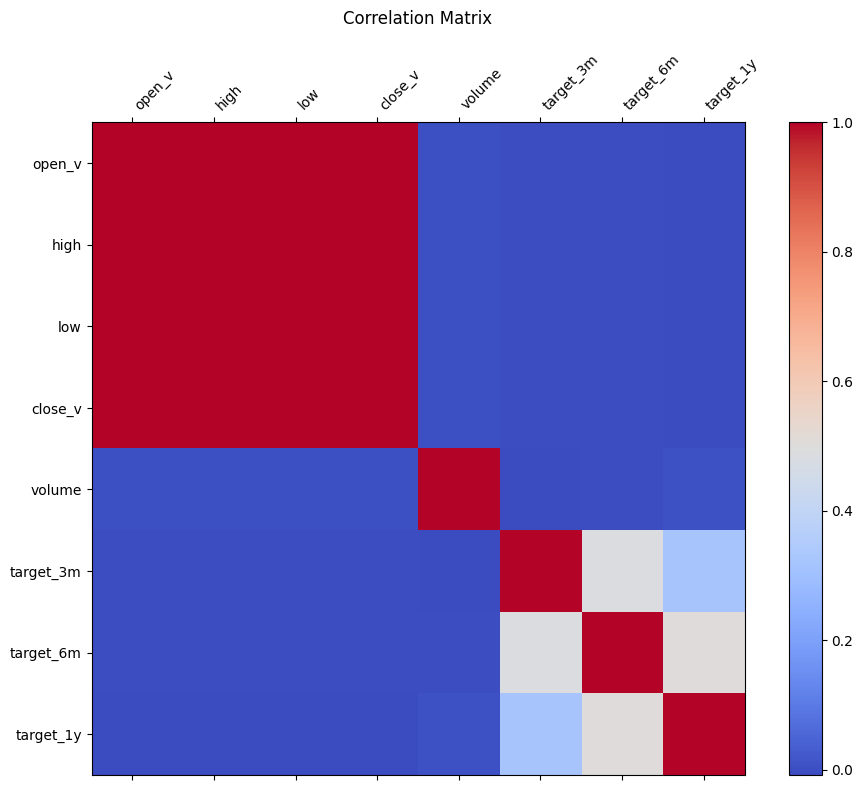

In [39]:
# Raw price and volume data
plot_correlation_heatmap(df, price_cols + targets)

- **Grupo de acciones corporativas y eventos discretos:** Los eventos como dividendos (pagos que la empresa distribuye entre sus accionistas a partir de sus beneficios)  y splits (acciones contables por las que las acciones se multiplican dividiendo proporcionalmente su precio para hacerlas más accesibles) suelen alterar el comportamiento de los inversores y, por tanto, afectar al rendimiento futuro. Existe una correlación moderada entre is_stock_split y stock_split. Entre dividends y is_dividend_day existe una baja correlación, posiblemente porque la mayoría de días is_dividend_day y dividends son casi siempre 0. La relación de estas variables con los targets es de una correlación muy baja. 
Los dividendos y splits no muestran una correlación significativa con la rentabilidad futura de las acciones en los horizontes definidos. 

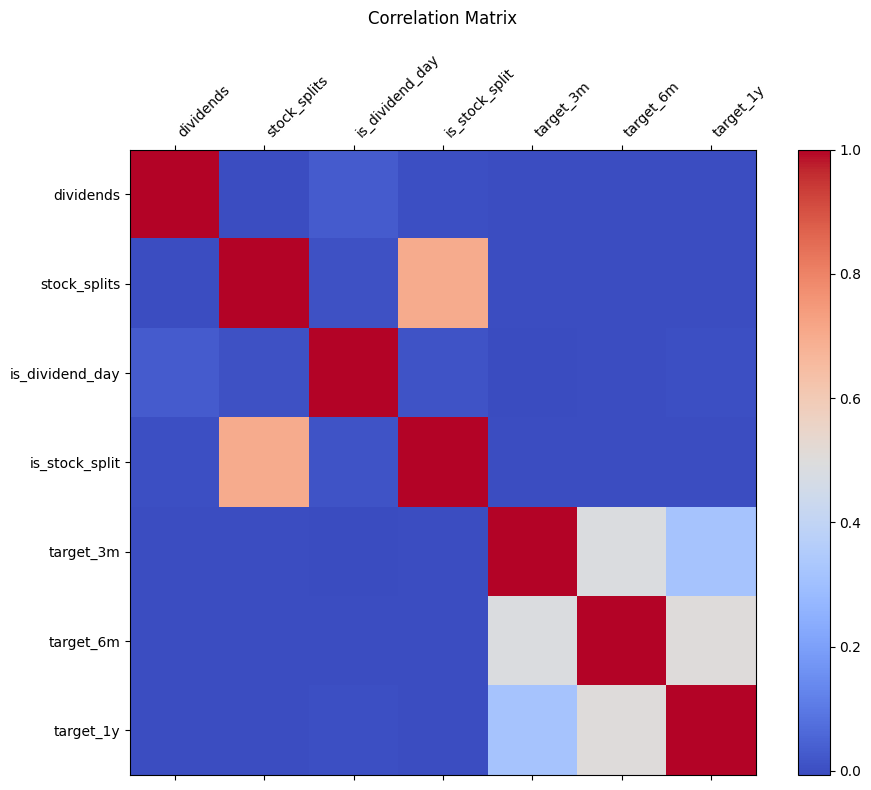

In [40]:
# Corporate actions and event flags
plot_correlation_heatmap(df, corporate_actions + targets)

- **Grupo devariaciones diarias y retornos:**  daily_return, close_change_pct y log_return tienen poca correlación, aunque se calculan en base a las mismas variables. gap_open (mide el salto de apertura con respecto al cierre anterior) y close_change_pct (mide el cambio de cierre respecto al día anterior) están muy correlacionadas. Descartaremos la variable **gap_open**. La correlación de estas variables con los targets es baja.

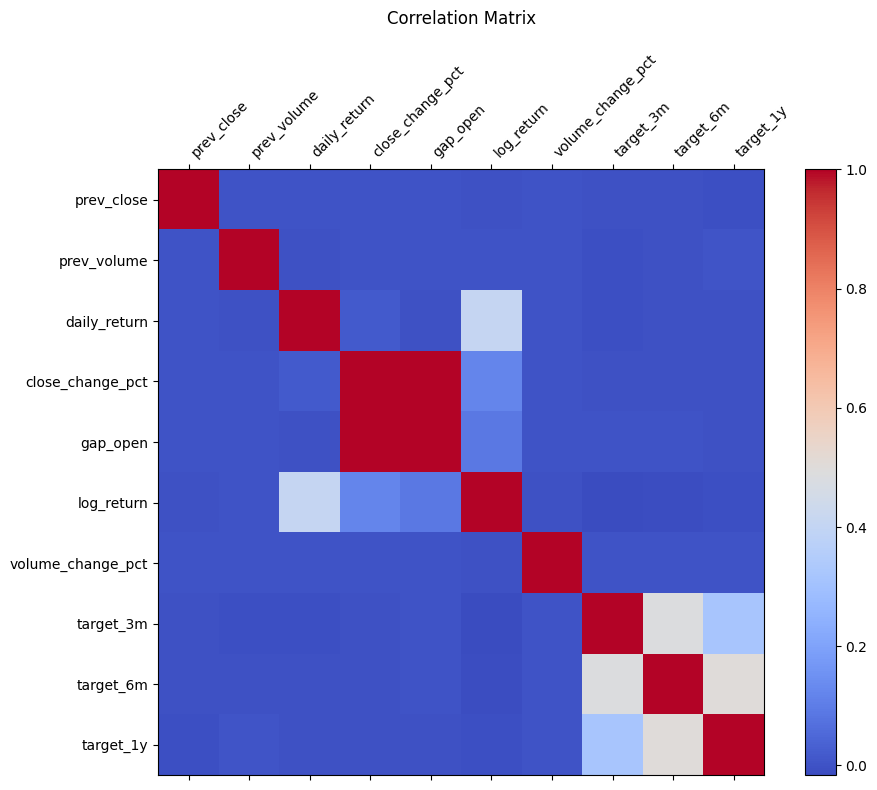

In [41]:
# Daily return and percentage change features
plot_correlation_heatmap(df, return_features + targets)

- **Grupo de variables de volatilidad y rango:** Este grupo incluye variables que miden la amplitud del movimiento diario de precios (price_range, intraday_volatility), así como medias más avanzadas como el true_range, sus componentes (tr_1, tr_2 y tr_3) y el indicador técnico atr_14. Estas métricas son fundamentales para caracterizar la volatilidad de un activo a corto y medio plazo. 

Recordemos el significado de las variables: 
1. **tr_1**: rango del día (diferencia entre máximo y mínimo intradía)
2. **tr_2**: diferencia entre el máximo del día y el cierre anterior (gap alcista)
3. **tr_3**: diferencia entre el mínimo del día y el cierre anterior (gap bajista)
4. **atr_14**: media móvil de true_range durante los últimos 14 días.
5. **price_range**: diferencia entre el precio más alto y más bajo del día.
6. **intraday_volatility**: price_range normalizado respecto al precio de apertura.
7. **true_range**: Medida que detecta gaps entre sesiones. Si no hay un cap significativo entre el cierre anterior y la apertura actual, entonces true_range y price_range suelen ser parecidas. Los gaps (alcistas y bajistas) son aperturas muy por encima o por debajo de mercado.

price_range y true_range miden conceptos similares, pero true_range es más completa al capturar movimientos entre sesiones. Por eso, no siempre están altamente correlacionadas, especialmente si hay muchos gaps de apertura.

Conservaremos solamente true_range, atr_14 e intraday_volatility. Esta limpieza evita redundancia, mejorará la eficiencia de los modelos y posiblemente reducirá el overfitting.


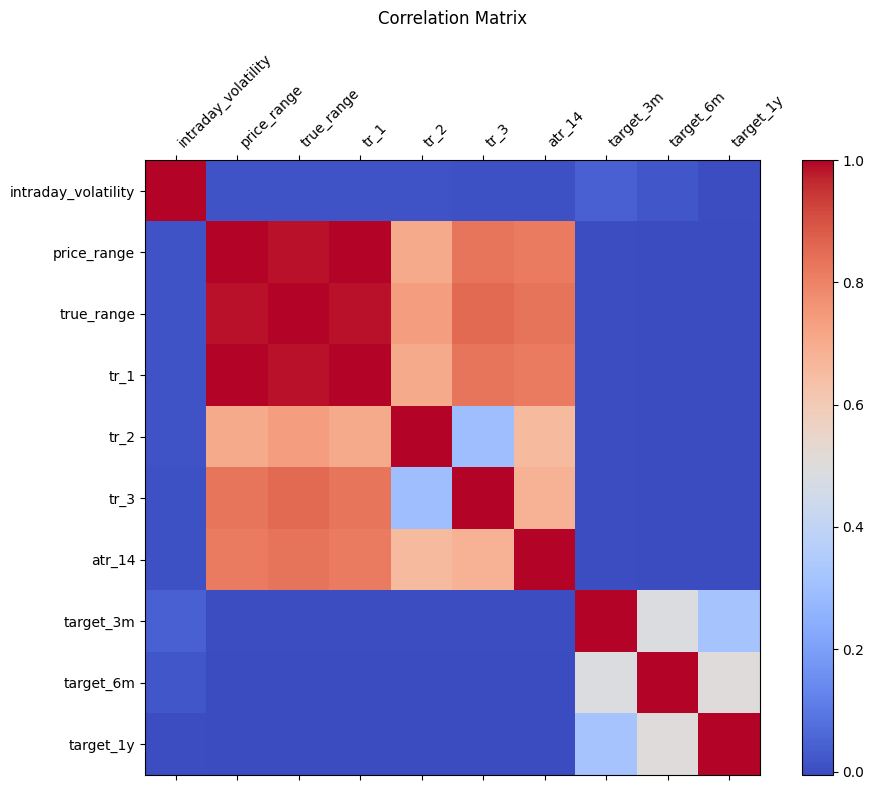

In [42]:
# Volatility and range-based indicators
volatility_features = ['intraday_volatility', 'price_range', 'true_range','tr_1', 'tr_2', 'tr_3', 'atr_14']
plot_correlation_heatmap(df, volatility_features + targets)


- **Grupo de indicadores técnicos:** Utilizados ampliamente en análisis cuantitativo, incluyen:
    - Medias móviles: Medias móviles simples (SMA), exponenciales(EMA), bandas de Bollinger (calculadas a  partir de una media móvil ± 2 desviaciones estándar. Indican niveles de sobrecompra( sobreventa). Todas están muy corelacionadas entre sí, ya que derivan directamente del precio con distintas ventanas de suavizado.
    
    - Indicadores de momentum: Momentum (diferencia entre el cierre actual y el de hace 10 días), roc (Variante porcentual de momentum) y rsi_14 (Relative Strenght Index): Deberían estar relacionadas, pero la correlación de Pearson es sensible a la escala. momentum está en unidades de precio mientras que roc está en proporciones. 
    
    - MACD: macd_signal line es la diferencia entre ema_12 y ema_26. No está fuertemente correlacionada con ellas. macd_signal es la media móvil exponencial a 9 días de la macd_line y se usa para detectar cruces como señales de compra/venta. macd_histogram es la diferencia entre macd_line y macd_signal. Representa la aceleración del momentum. Están correlacionaadas moderadamente. 
    
    - rel_volume: volumen relativo. Compara el volumen actual frente a su media reciente. Se emplea para detectar movimientos con fuerza. Se comporta de forma independiente con las demás. 

    La medida más correlacionada con las targets es el rsi_14.  Este comportamiento podría ser coherente con su naturaleza de oscilador técnico que capta dinámicas de sobrecompra o sobreventa a corto plazo, lo que lo convierte en un buen candidato como variable predictora.

   Eliminaremos sma_5, bollinger_upper, bollinger_lower, ema_12 y  madcd_line


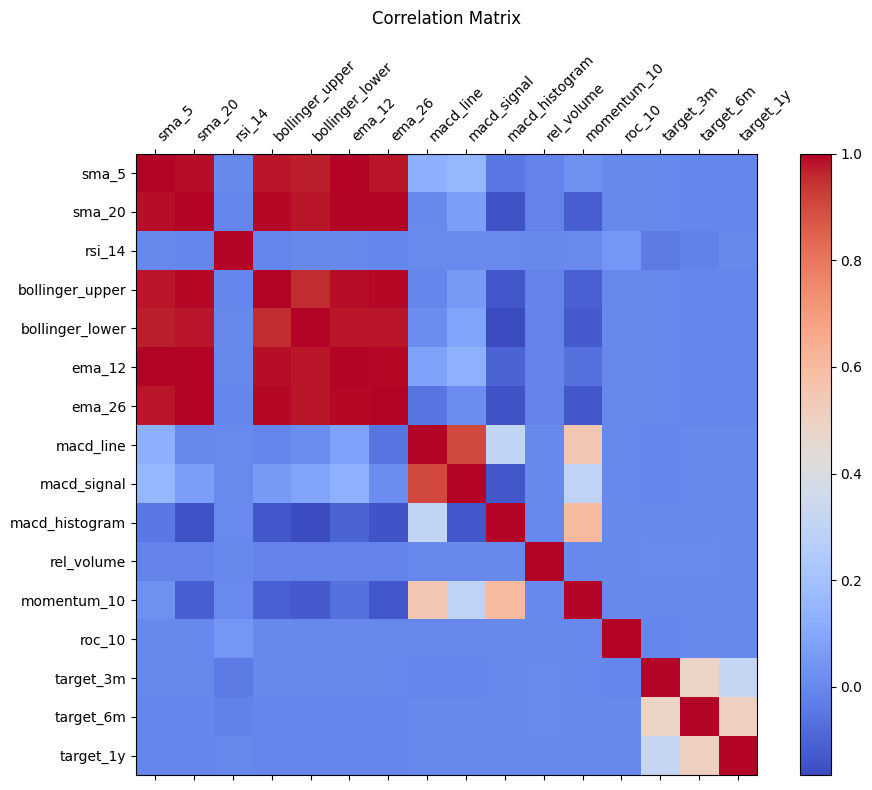

In [43]:

# Technical indicators (momentum, moving averages, oscillators)
technical_indicators = ['sma_5', 'sma_20', 'rsi_14', 'bollinger_upper', 'bollinger_lower','ema_12', 'ema_26', 'macd_line', 'macd_signal', 'macd_histogram','rel_volume', 'momentum_10', 'roc_10']
plot_correlation_heatmap(df, technical_indicators + targets)


- **Grupo de estructura y patrones de velas japonesas:** Este grupo incluye medidas derivadas de la forma de la vela diaria:
    - candle_body (Cuerpo).
    - upper_wick / lower_wick (mechas superior e inferior).
    - candle_color (direción del movimiento, 1 si la vela es alcista y 0 si es bajista).

Tienen correlaciones moderadas entre sí, lo cual tiene sentido porque juntas forman la estructura de la vela.  No eliminaremos  ninguna variable.

/tmp/ipykernel_3347/1619737512.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df[columns].corr()


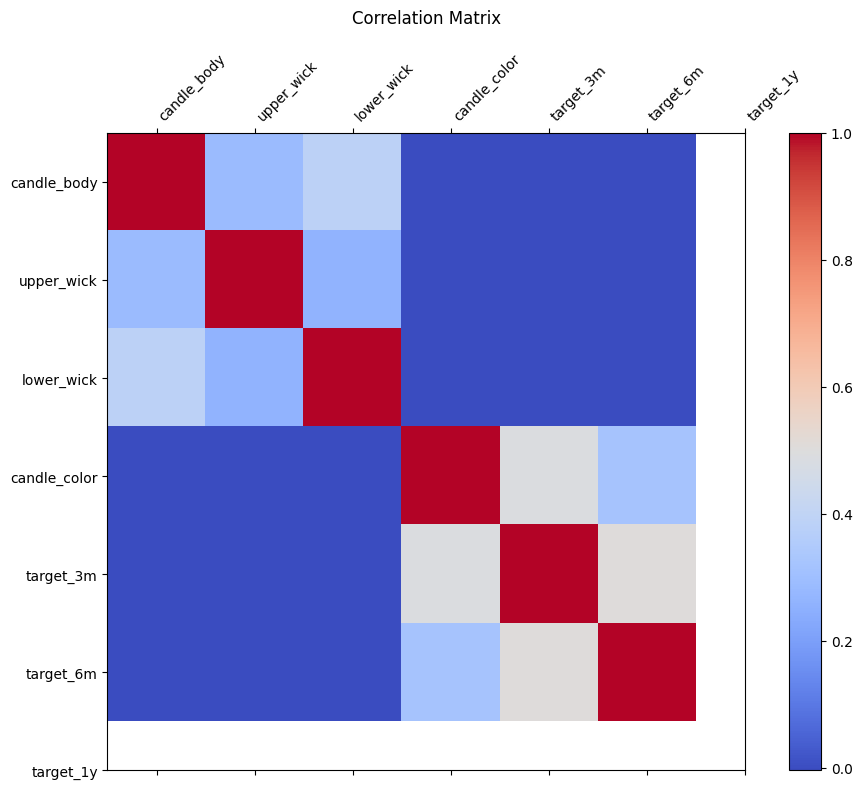

In [45]:
# Candlestick structure and patterns
candle_features = ['candle_body', 'upper_wick', 'lower_wick', 'candle_color']
plot_correlation_heatmap(df, candle_features + targets)

- **Grupo de retornos históricos acumulados:** Existe cierta correlación entre los retornos futuros (ret_next_3m, ret_next_6m, ret_next_1y) y sus respectivos targets. Esto es coherente, ya que los targets binarios se construyen directamente a partir de estos retornos aplicando un umbral del 10%. Los ret_next_* permiten cuantificar la magnitud exacta del rendimiento futuro más allá de la simple clasificación binaria, por lo que se conservarán como referencia en el análisis exploratorio y diagnóstico del comportamiento del modelo.

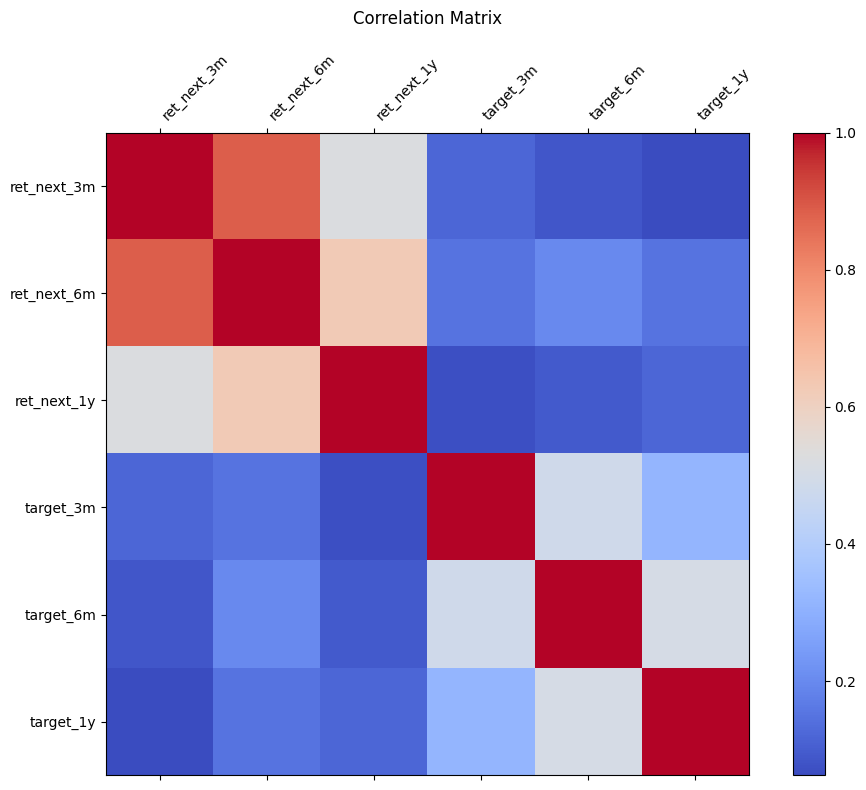

In [46]:
forward_returns = ['ret_next_3m', 'ret_next_6m', 'ret_next_1y']
plot_correlation_heatmap(df, forward_returns + targets)

- **Grupo de variables derivadas o estadísticas personalizadas:** Incluye variables estadísticas simples calculadas a partir de los retornos diarios, como la delta (diferencia entre pérdidas y ganancias), gain, loss y la var_95 (Value at Risk estimado al 95%). Estas variables no corresponden a indicadores técnicos clásicos, pero pueden aportar perspectiva sobre el riesgo y dirección reciente del precio. 
    - gain y loss tienen cierta correlación negativa.
    - gain y delta tienen una correlación moderadamente alta. Si loss es más o menos estable o con poca varianza, delta se mueve principalmente con gain. No obstante, aunque pueda introducir redundancia, mantendremos ambas.

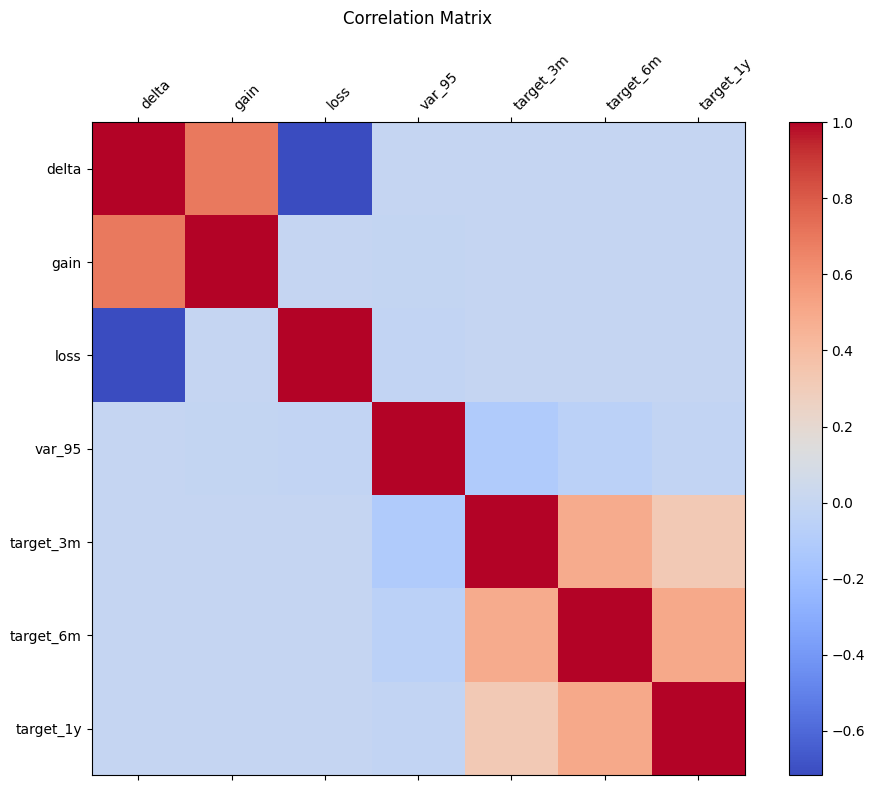

In [48]:
# Other derived or statistical features
misc_features = ['delta', 'gain', 'loss', 'var_95']
plot_correlation_heatmap(df, misc_features + targets)

Vamos entonces a eliminar las siguientes variables: 

In [49]:
columns_to_drop = [
    'open_v', 'high', 'low',
    'dividends', 'stock_splits', 'is_dividend_day', 'is_stock_split',
    'gap_open','price_range','tr_1','tr_2','tr_3',
    'sma_5', 'bollinger_upper', 'bollinger_lower', 'ema_12', 'macd_line'
]

df = df.drop(columns=columns_to_drop)

/tmp/ipykernel_3347/1619737512.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df[columns].corr()


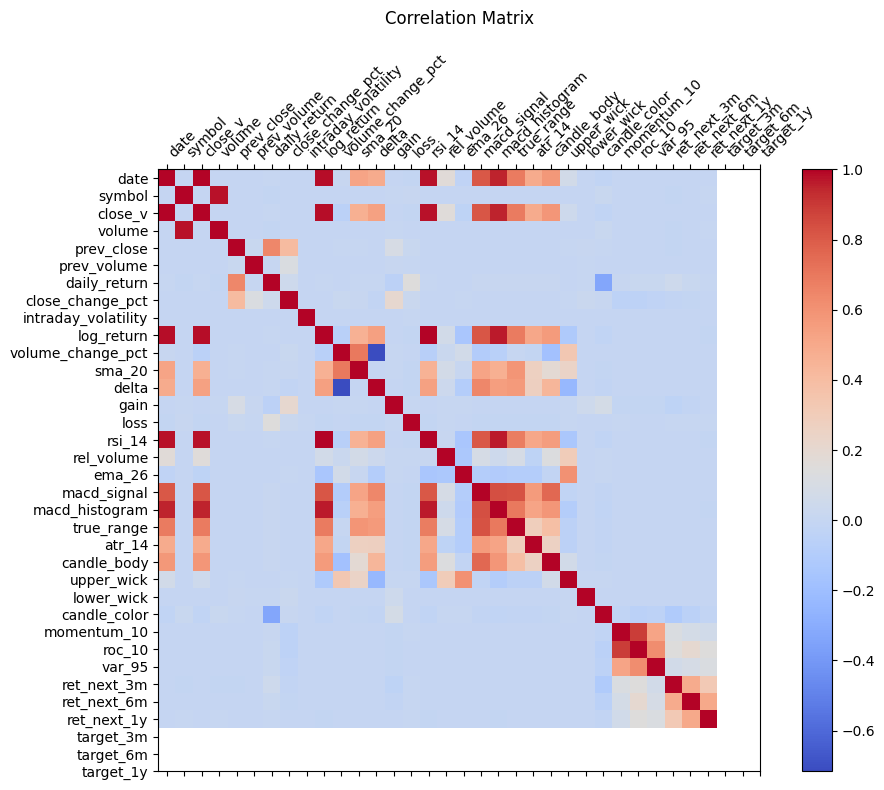

In [55]:
# Final heatmap:

plot_correlation_heatmap(df, df.columns)


In [56]:
df.dtypes

date                   datetime64[ns]
symbol                       category
close_v                       float64
volume                        float64
prev_close                    float64
prev_volume                   float64
daily_return                  float64
close_change_pct              float64
intraday_volatility           float64
log_return                    float64
volume_change_pct             float64
sma_20                        float64
delta                         float64
gain                          float64
loss                          float64
rsi_14                        float64
rel_volume                    float64
ema_26                        float64
macd_signal                   float64
macd_histogram                float64
true_range                    float64
atr_14                        float64
candle_body                   float64
upper_wick                    float64
lower_wick                    float64
candle_color                 category
momentum_10 

##### **4.4 NORMALIZACIÓN DE LOS DATOS**

A continuación normalizaremos los datos, para Naive Bayes y SVM emplearemos Standar Scaler y para LSTM MinMaxScaler. Para tal fin, en el apartado funciones hemos generado la función prepare_data.

- Naive Bayes asume que cada feature sigue una distribución normal. StandarScaler transforma los datos a media 0 y desviación típica 1, lo cual se ajusta a esta asunción.

- SVM usa distancias en un espacio de características. Si una variable tiene una escala mucho mayor que otra, dominará la función de decisión.  StandarScaler equilibria las escalas.

- LSTM / Redes neuronales suelen funcionar mejor con datos en rangos [0,1] que [-1,1]. Las activaciones (ReLu, tanh, sigmoid) están diseñadas para trabajar en estos rangos. 




In [57]:
targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_standard, scaler_standard = prepare_data(df, targets, scaler_type='standard', drop_cols=['date', 'symbol'])
df_processed_minmax, scaler_minmax = prepare_data(df, targets, scaler_type='minmax', drop_cols=['date', 'symbol'])

df_processed_standard.dtypes
print(f"Shapes: \n df_processed_standard: {df_processed_standard.shape} \n  df_processed_minmax: {df_processed_minmax.shape}")

Shapes: 
 df_processed_standard: (10792903, 33) 
  df_processed_minmax: (10792903, 33)


#### **5. TRAINING**

##### **5.1 NAIVE BAYES**

Como primer modelo de clasificación se ha empleado Naive Bayes con la variante GaussianNB. Se trata de un algoritmo rápido y eficiente, incluso con conjuntos de datos de gran tamaño como el que se emplea en este trabajo.  Esto permite realizar una evaluación inicial del rendimiento sin incurrir en costes computacionales elevados. 

Además, este algoritmo no requiere un alto número de hiperparámetros, lo que simplifica su entrenamiento y reduce el riesgo de sobreajuste.  En este trabajo se emplea GridSearchCV ara ajustar el hiperparámetro `var_smoothing`, que controla la estabilidad del modelo frente a variables con varianza baja. Esta búsqueda permite mejorar el rendimiento sin apenas penalización computacional.

Una limitación importante de GaussianNB es que no admite valores nulos en los datos. Pese a la limpieza de los mismos en puntos anteriores, en las siguientes celdas podemos ver como algunas características relativas a las rentabilidades históricas acumuladas todavía presentan nulos. Esto se debe mayoritariamente a que hay empresas de más reciente creación que el intervalo calculado.  Por lo tanto, se debe realizar una imputación por media a las columnas con datos faltantes. Esta estrategia permite conservar el mayor número de observaciones sin introducir sesgos graves.

A continuación, se define `X` e `y`, para aplicar un `train_split_test` sin shuffle para evitar romper la secuencia cronológica. Si no lo hiciésemos, estaríamos entrenando con datos que ocurren después de los que se usan para test, lo que iría en contra de la estructura temporal de los mercados financieros. En estos datos importa el orden temporal: Los precios de hoy dependen de los de ayer. 

Finalmente, es necesario tener en cuenta que las variables están estandarizadas, ya que Naive Bayes asume distribución normal de sus variables. Las variables categóricas deben estar codificadas numéricamente, como es el caso de 
`candle_color`.

Existen otras variantes del algoritmo como MultinomialNB (orientada a datos discretos como recuentos) y BernouilliNB (para variables binarias). No se han considerado en este trabajo porque el conjunto de datos está compuesto por variables continuas. 


##### 5.1.1 Preprocesado de los datos

In [58]:
df_processed_standard.describe()

,close_v,volume,prev_close,prev_volume,daily_return,close_change_pct,intraday_volatility,log_return,volume_change_pct,sma_20,...,candle_color,momentum_10,roc_10,var_95,ret_next_3m,ret_next_6m,ret_next_1y,target_3m,target_6m,target_1y
count,1.079290e+07,1.079290e+07,1.079290e+07,1.079290e+07,1.079290e+07,1.079290e+07,1.079290e+07,1.079290e+07,1.079290e+07,1.079290e+07,...,1.079290e+07,1.079290e+07,1.079290e+07,1.079290e+07,1.079290e+07,1.079290e+07,1.079290e+07,1.079290e+07,1.079290e+07,1.079290e+07
mean,-1.603064e-18,-1.024381e-17,-4.709124e-18,-1.012531e-17,-5.080759e-18,5.239995e-19,-4.830654e-17,-1.522088e-18,-1.643388e-19,3.211395e-18,...,-9.948346e-17,-2.053206e-19,-1.110961e-17,3.957492e-15,-6.689419e-18,8.105514e-18,6.700216e-17,3.108018e-01,4.042508e-01,4.881685e-01
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.628219e-01,4.907465e-01,4.998600e-01
min,-5.739146e-03,-5.613646e-02,-2.343090e-02,-5.613697e-02,-1.758678e+01,-1.724105e+01,-6.973890e+01,-2.315587e+02,-1.964296e-03,-2.241945e-02,...,-1.052650e+00,-6.418769e+02,-9.361615e+00,-2.696815e+01,-7.079998e+00,-7.792761e+00,-8.084926e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,-5.739119e-03,-5.555332e-02,-5.747152e-03,-5.555376e-02,-1.978112e-01,-1.526749e-02,-3.204552e-01,-3.370670e-01,-1.499975e-03,-5.870595e-03,...,-1.052650e+00,6.220926e-04,-3.041397e-02,-3.257930e-01,-8.518575e-02,-1.545230e-01,-1.022703e-01,0.000000e+00,0.000000e+00,0.000000e+00
50%,-5.739089e-03,-5.325094e-02,-5.747121e-03,-5.325191e-02,-7.903045e-03,-1.306795e-03,-1.555632e-01,-5.985741e-03,-1.322917e-03,-5.870564e-03,...,9.499835e-01,6.221007e-04,-2.793190e-03,2.710673e-01,-1.287314e-02,-3.233172e-02,-3.026898e-02,0.000000e+00,0.000000e+00,0.000000e+00
75%,-5.739014e-03,-4.375642e-02,-5.747046e-03,-4.375756e-02,1.810309e-01,1.339732e-02,1.267402e-01,3.387532e-01,-1.089856e-03,-5.870489e-03,...,9.499835e-01,6.221107e-04,2.536635e-02,6.305165e-01,6.129463e-02,9.428111e-02,4.715826e-02,1.000000e+00,1.000000e+00,1.000000e+00
max,3.928849e+02,9.096044e+01,3.922650e+02,9.097066e+01,1.916165e+03,3.273400e+03,1.885736e+03,2.320003e+02,2.361084e+03,3.504945e+02,...,9.499835e-01,6.659485e+02,1.870756e+03,1.706261e+00,1.744985e+03,1.497668e+03,1.171779e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [59]:
df_processed_standard.shape

(10792903, 33)

In [60]:
extract_basic_info(df_processed_standard,are_all_symbols=False)

Shape: (10792903, 33)

Missing values (sorted):
Series([], dtype: int64)

Columns with missing values (sorted):
[]


##### 5.1.2 Entrenamiento del modelo, predicciones y evaluación

In [61]:
def train_naive_bayes(
    df: pd.DataFrame,
    features: List[str],
    target_col: str,
) -> Tuple[GaussianNB, pd.Series, pd.Series,pd.Series]:
    """
    Trains a Naive Bayes classifier with GridSearchCV and returns predictions and evaluation metrics.

    Args:
       - df (pd.DataFrame): Preprocessed DataFrame with features and target.
       - target_col (str): Name of the target column to predict.

    Returns:
        model (GaussianNB): Trained Naive Bayes model.
        y_test (pd.Series): True target values for test set.
        y_pred (pd.Series): Predicted class labels.
        metrics (dict): Dictionary with accuracy, f1, roc_auc, and confusion matrix.
    """
    X = df[features]
    y = df[target_col]

    # Impute missing values
    X = pd.DataFrame(SimpleImputer(strategy='mean').fit_transform(X), columns=features)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Grid search
    param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]}
    grid = GridSearchCV(GaussianNB(), param_grid, scoring='f1', cv=3)
    grid.fit(X_train, y_train)
    model = grid.best_estimator_

    # Prediction
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    return model, y_test, y_pred,y_prob

Accuracy: 0.3166
F1 Score: 0.4749
ROC AUC: 0.6899
Confusion Matrix:
 [[  16222 1466907]
 [   8287  667165]]
Precision: 0.3126
Recall: 0.9877


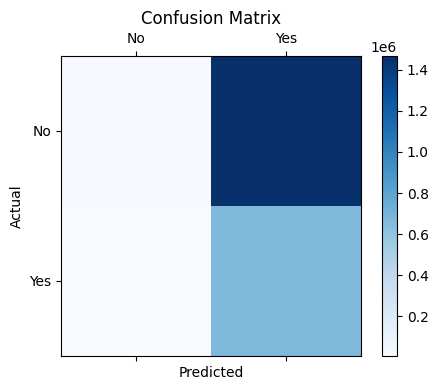

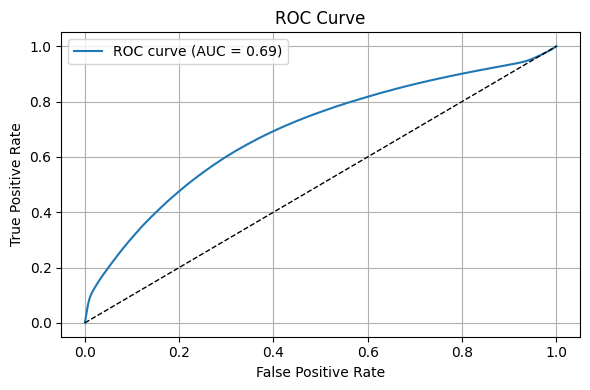

In [63]:
# Variables definition
target_col = 'target_3m'
df_processed_standard_3m = df_processed_standard.drop(columns=['ret_next_3m'])

features = [col for col in df_processed_standard_3m.columns if col not in targets]

# Model training and evaluation
model_bayes_3m, y_test_bayes_3m, y_pred_bayes_3m,y_prob_bayes_3m =train_naive_bayes(df_processed_standard_3m, features,target_col)
acc_bayes_3m, f1_bayes_3m, roc_bayes_3m,cm_bayes_3m,precission_bayes_3m,recall_bayes_3m = model_evaluation(y_test_bayes_3m, y_pred_bayes_3m,y_prob_bayes_3m)

Para un objetivo target_3m, el modelo tendió a clasificar excesivamente hacia la clase positiva, tal y como indica la alta tasa de recall (~0,98), combinada con valores bajos de precisión (por debajo de 0.4). Esto se traduce en un gran número de falsos positivos, lo cuál es especialmente problemático en un contexto de inversión, donde una predicción errónea puede suponer la selección de activos que no alcanzan el rendimiento esperado. 

In [64]:
# Variables definition
target_col = 'target_6m'
df_processed_standard_6m = df_processed_standard.drop(columns=['ret_next_6m'])

features = [col for col in df_processed_standard_6m.columns if col not in targets]

Accuracy: 0.4063
F1 Score: 0.5762
ROC AUC: 0.7300
Confusion Matrix:
 [[   5643 1278526]
 [   3068  871344]]
Precision: 0.4053
Recall: 0.9965


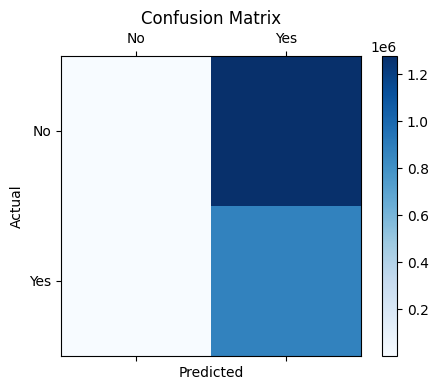

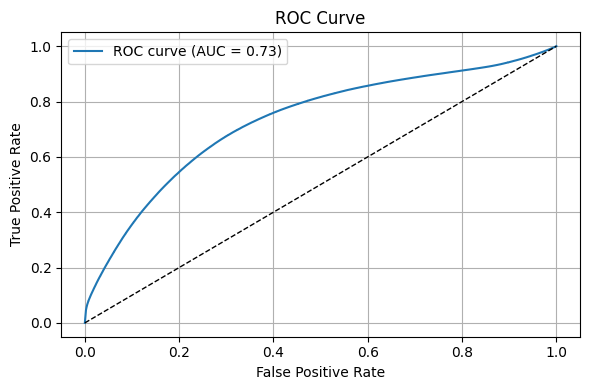

In [65]:
# Model training and evaluation

model_bayes_6m, y_test_bayes_6m, y_pred_bayes_6m,y_prob_bayes_6m =train_naive_bayes(df_processed_standard_6m, features,target_col)
acc_bayes_6m, f1_bayes_6m, roc_bayes_6m,cm_bayes_6m,precission_bayes_6m,recall_bayes_3m = model_evaluation(y_test_bayes_6m, y_pred_bayes_6m,y_prob_bayes_6m)

Accuracy: 0.4889
F1 Score: 0.6564
ROC AUC: 0.5005
Confusion Matrix:
 [[   1635 1102745]
 [    562 1053639]]
Precision: 0.4886
Recall: 0.9995


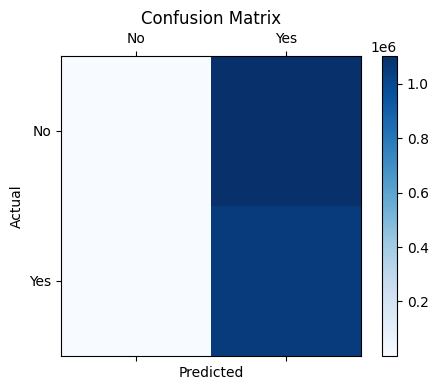

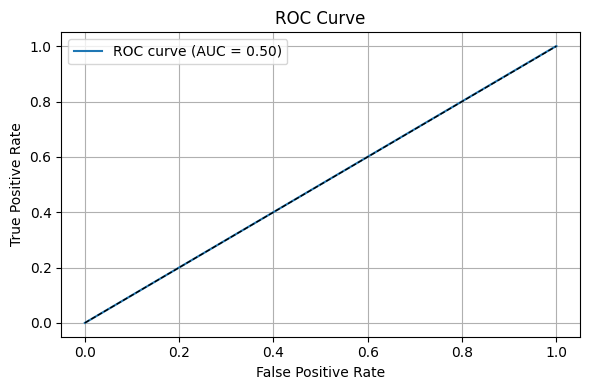

In [66]:
# Variables definition
target_col = 'target_1y'
df_processed_standard_1y = df_processed_standard.drop(columns=['ret_next_1y'])

features = [col for col in df_processed_standard_1y.columns if col not in targets]

# Model training and evaluation

model_bayes_1y, y_test_bayes_1y, y_pred_bayes_1y,y_prob_bayes_1y =train_naive_bayes(df_processed_standard_1y, features,target_col)
acc_bayes_1y, f1_bayes_1y, roc_bayes_1y,cm_bayes_1y,precission_bayes_1y,recall_bayes_1y = model_evaluation(y_test_bayes_1y, y_pred_bayes_1y,y_prob_bayes_1y)

En el horizonte a 6 meses (target_6m), el modelo presentó un rendimiento algo más sólido, con una ROC AUC de 0.7,  si bien este rendimiento debe ser matizado con el análisis de las demás métricas clave. El modelo sigue teniendo un recall muy elevado, lo cual implica que es capaz de identificar casi todos los casos positivos. Sin embargo, esta capacidad viene a costa de una precisión baja, lo que significa que gran parte de las predicciones positivas son, en realidad, falsos positivos. 

Después de evaluar el comportamiento de Naive Bayes como modelo baseline, vamos a probar SVM (Support Vector Machines), que es una buena siguiente opción porque nos va a permitir modelar relaciones no lineales (por ejemplo con el kernel RBF) y permite ajustar el ligero desbalance entre clases que vimos que tienen las clases durante la etapa de preparación de los targets.

##### **5.2 SUPPORT VECTOR MACHINES (SVM)**

Support Vector Machines (SVM) es un algoritmo supervisado de clasificación que busca encontrar el hiperplano óptimo que separa las clases en el espacio de características. Su objetivo es maximizar el margen entre las clases, es decir, la distancia entre el hiperplano y los puntos más cercanos (los support vectors).

A diferencia de Naiva Bayes, no asume ninguna distribución de los datos. Puede capturar relaciones no lineales entre variables usando kernels (por defecto, RBF).

Es eficaz en espacios de alta dimensión, como ocurre con indicadores financieros y técnicos; y permite tratar el desbalanceo de clases usando el parámetro `class_weight='balanced'`. 

Es un algoritmo robusto ante ruido moderado y puede generalizar bien en problemas con solapamiento entre clases.

A continuación se resumen algunos de los parámetros más importantes :

- C: Controla el trade-off entre el margen ancho y errores de clasificación. Un C bajo permite un margen más amplio (mayor tolerancia al error).

- gamma: Controla el radio de influencia de cada punto de entrenamiento. Es clave cuando se emplea `kernel='rbf'` (radial basis function), que es el más usado para problemas no lineales.  Valores muy bajos pueden producir underfitting (fronteras muy suaves), mientras que valores muy altos pueden producir overfitting (fronteras muy ajustadas). Por defecto se recomienda 'scale' (Automático: 1 / (n_features * X.var())), pero también se probará 'auto' (1/n_features y menos sensible a la varianza). También es posible configurar valores numéricos. 

- class_weight: Muy útil en problemas desbalanceados. 'balanced' ajusta los pesos automáticamente.

- kernel: Transforma el espacio original de las varaibles en un espacio de mayor dimensión, donde es más fácil encontrar un hiperplano que separe linealmente las clases. Existen distintos tipos de kernels:
    - `linear`: No transforma los datos. Se emplea si hay separación lineal o muchas features.
    - `rbf`: Usa funciones gaussianas para proyectar. Ideal para datos no lineales como los nuestros.
    - `poly`: Aplica una transformación polinómica a los datos. Para casos con relaciones cuadáticas o cúbicas. 
    - `sigmoid`: Similar a neuronas (tangente hiperbólica). Es menos robusto y poco usado. 

    Como estamos entrenando millones de filas, usaremos rbf y linear, pues no sabemos si hay una separación no lineal de los datos.  


##### 5.2.1 Entrenamiento del modelo base. predicciones y evaluación

Para poder probar SVM, necesitamos reducir radicalmente el tamaño del dataset. SVM no escala bien con millones de muestras por su complejidad computacional. 

In [67]:
top_symbols = (
    df.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(20) 
    .index
)
df_svm = df[df["symbol"].isin(top_symbols)].copy()

In [68]:
targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_standard_svm, scaler_standard_svm = prepare_data(df_svm, targets, scaler_type='standard', drop_cols=['date', 'symbol'])

In [69]:
def train_svm_fast(
    df: pd.DataFrame,
    features: List[str],
    target_col: str,
) -> Tuple[SVC, pd.Series, pd.Series, pd.Series]:
    """
    Trains a basic SVM classifier without GridSearch and returns predictions and probabilities.

    Args:
        df (pd.DataFrame): Preprocessed DataFrame with features and target.
        features (List[str]): List of feature column names.
        target_col (str): Name of the target column to predict.

    Returns:
        model (SVC): Trained SVM model.
        y_test (pd.Series): True test labels.
        y_pred (pd.Series): Predicted labels.
        y_prob (pd.Series): Predicted probabilities for class 1.
    """

    X = df[features]
    y = df[target_col]

    print("Imputing missing values...")
    # Impute missing values
    X = pd.DataFrame(SimpleImputer(strategy='mean').fit_transform(X), columns=features)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Train SVM with basic configuration
    model = SVC(kernel='linear', C=1, class_weight='balanced', probability=True)

    model.fit(X_train, y_train)
    print("model fit")
    # Predict
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    print()

    return model, y_test, y_pred, y_prob


In [71]:
df_processed_standard_svm.shape

(125066, 33)

In [72]:
# Variables definition
target_col = 'target_6m'
df_processed_standard_svm_6m = df_processed_standard_svm.drop(columns=['ret_next_6m'])

features = [col for col in df_processed_standard_svm_6m.columns if col not in targets]
print(f"features: {features}")

features: ['close_v', 'volume', 'prev_close', 'prev_volume', 'daily_return', 'close_change_pct', 'intraday_volatility', 'log_return', 'volume_change_pct', 'sma_20', 'delta', 'gain', 'loss', 'rsi_14', 'rel_volume', 'ema_26', 'macd_signal', 'macd_histogram', 'true_range', 'atr_14', 'candle_body', 'upper_wick', 'lower_wick', 'candle_color', 'momentum_10', 'roc_10', 'var_95', 'ret_next_3m', 'ret_next_1y']


In [73]:
# Model training and evaluation (fast version)
model_svm_6m_fast, y_test_svm_6m_fast, y_pred_svm_6m_fast,\
 y_prob_svm_6m_fast = train_svm_fast(
    df_processed_standard_svm_6m, features, target_col
)


Imputing missing values...
model fit



Accuracy: 0.8099
F1 Score: 0.7752
ROC AUC: 0.9019
Confusion Matrix:
 [[12061  3093]
 [ 1662  8198]]
Precision: 0.7261
Recall: 0.8314


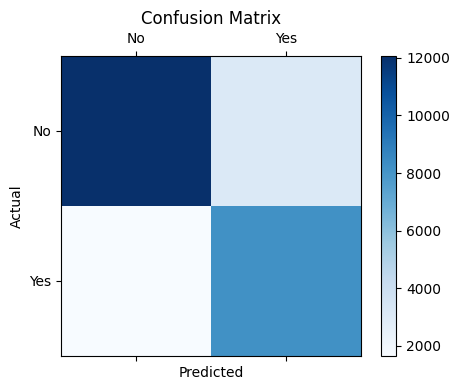

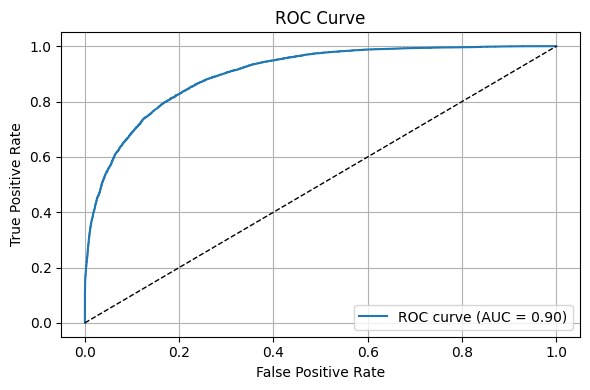

In [74]:
acc_svm_6m, f1_svm_6m, roc_svm_6m, cm_svm_6m, precision_svm_6m, recall_svm_6m = model_evaluation(
    y_test_svm_6m_fast, y_pred_svm_6m_fast,y_prob_svm_6m_fast
)

##### 5.2.2 Reducción de la dimensionalidad y ajuste del conjunto de entrenamiento. 

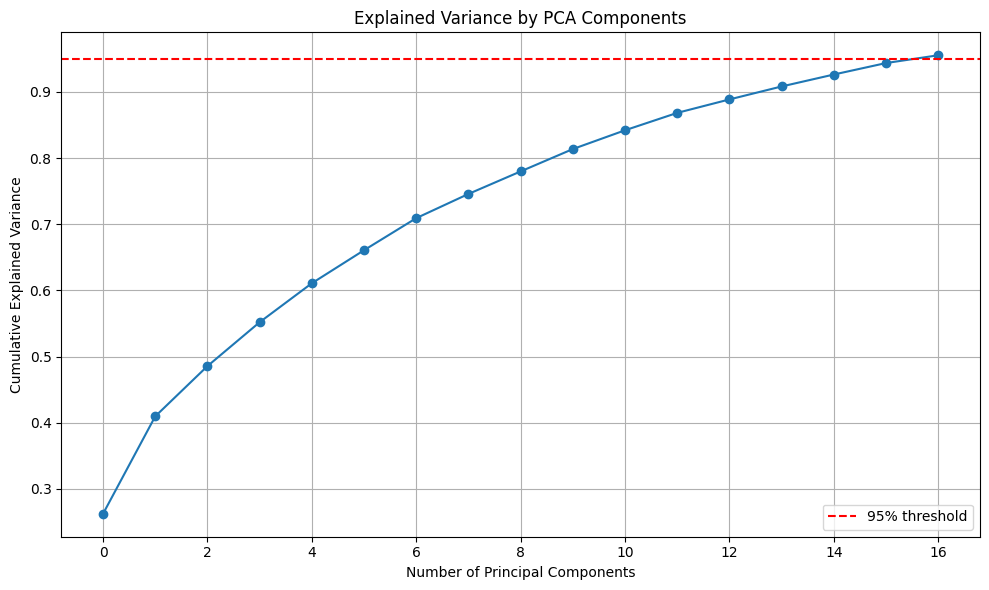

In [79]:
df_pca_6m, pca_model = apply_pca(df_processed_standard_svm_6m, targets=['target_6m'])

In [80]:
features_pca = [col for col in df_pca_6m.columns if col != target_col]

In [81]:
model_svm_6m_fast_pca, y_test_svm_6m_fast_pca, y_pred_svm_6m_fast_pca, \
 y_prob_svm_6m_fast_pca = train_svm_fast(
    df_pca_6m, features_pca, target_col
)
acc_svm_6m, f1_svm_6m, roc_svm_6m, cm_svm_6m, \
precision_svm_6m, recall_svm_6m = model_evaluation(
    y_test_svm_6m_fast_pca, y_pred_svm_6m_fast_pca,y_prob_svm_6m_fast_pca
)


Imputing missing values...


##### 5.2.3 kernel RBF y PCA

In [ ]:
def train_svm_rbf(
    df: pd.DataFrame,
    features: List[str],
    target_col: str
) -> Tuple[SVC, pd.Series, pd.Series, pd.Series]:
    """
    Trains a more complex SVM model using RBF kernel with PCA-reduced data.

    Args:
        df (pd.DataFrame): DataFrame with PCA-transformed features and target.
        features (List[str]): List of feature column names.
        target_col (str): Name of the target column to predict.

    Returns:
        model (SVC): Trained SVM model.
        y_test (pd.Series): True test labels.
        y_pred (pd.Series): Predicted class labels.
        y_prob (pd.Series): Predicted probabilities for class 1.
    """
    print("[INFO] Imputing missing values...")
    X = pd.DataFrame(SimpleImputer(strategy='mean').fit_transform(df[features]), columns=features)
    y = df[target_col]

    print("[INFO] Splitting data...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    print("[INFO] Training SVM model with RBF kernel...")
    model = SVC(kernel='rbf', C=1, gamma='scale', class_weight='balanced', probability=True)
    model.fit(X_train, y_train)

    print("[INFO] Generating predictions...")
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    return model, y_test, y_pred, y_prob


In [ ]:
model_svm_6m_rbf_pca, y_test_svm_6m_rbf_pca, y_pred_svm_6m_rbf_pca, y_prob_svm_6m_rbf_pca = train_svm_rbf(
    df_pca_6m, features_pca, target_col
)

acc_svm_6m_rbf, f1_svm_6m_rbf, roc_svm_6m_rbf, cm_svm_6m_rbf, precision_svm_6m_rbf, recall_svm_6m_rbf = model_evaluation(
    y_test_svm_6m_rbf_pca, y_pred_svm_6m_rbf_pca, y_prob_svm_6m_rbf_pca
)

##### 5.2.4 GridSearch con kernel RBF y PCA

In [ ]:
def train_svm_gridsearch(
    df: pd.DataFrame,
    features: List[str],
    target_col: str,
    kernel: str
) -> Tuple[SVC, pd.Series, pd.Series, pd.Series]:
    """
    Trains an SVM model using RBF kernel with GridSearchCV for hyperparameter tuning.

    Args:
        df (pd.DataFrame): Input DataFrame with features and target.
        features (List[str]): List of feature column names (after PCA if used).
        target_col (str): Name of the binary classification target column.

    Returns:
        model (SVC): Trained SVM model with best hyperparameters.
        y_test (pd.Series): True labels of the test set.
        y_pred (pd.Series): Predicted class labels.
        y_prob (pd.Series): Predicted probabilities for class 1.
    """
    print("[INFO] Imputing missing values...")
    X = pd.DataFrame(SimpleImputer(strategy='mean').fit_transform(df[features]), columns=features)
    y = df[target_col]

    print("[INFO] Splitting data...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    print("[INFO] Running GridSearchCV...")
    svc_args = {
        'kernel': kernel,
        'class_weight': 'balanced',
        'probability': True
    }

    param_grid = {'C': [0.1, 1, 10]}
    if kernel == 'rbf':
        param_grid['gamma'] = ['scale', 0.1, 1]

    grid = GridSearchCV(
        estimator=SVC(**svc_args),
        param_grid=param_grid,
        scoring='f1',
        cv=2,
        verbose=2,
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    model = grid.best_estimator_

    print(f"[INFO] Best parameters: {grid.best_params_}")
    print("[INFO] Generating predictions...")
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    return model, y_test, y_pred, y_prob

In [ ]:
model_svm_6m_grid_rbf, y_test_svm_6m_grid_rbf, y_pred_svm_6m_grid_rbf, \
 y_prob_svm_6m_grid_rbf = train_svm_gridsearch(
    df_pca_6m, features_pca, target_col, kernel='rbf'
)
acc_svm_grid_rbf, f1_svm_grid_rbf, roc_svm_grid_rbf, cm_svm_grid_rbf, precision_svm_grid_rbf, \
recall_svm_grid_rbf = model_evaluation(
    y_test_svm_6m_grid_rbf, y_pred_svm_6m_grid_rbf, y_prob_svm_6m_grid_rbf
)

##### 5.2.5 GridSearch con kernel Lineal y PCA

In [ ]:
model_svm_6m_grid_lineal, y_test_svm_6m_grid_lineal, y_pred_svm_6m_grid_lineal, \
 y_prob_svm_6m_grid_lineal = train_svm_gridsearch(
    df_pca_6m, features_pca, target_col, kernel='linear'
)
acc_svm_grid_lineal, f1_svm_grid_lineal, roc_svm_grid_lineal, cm_svm_grid_lineal, precision_svm_grid_lineal, \
recall_svm_grid_lineal = model_evaluation(
    y_test_svm_6m_grid_lineal, y_pred_svm_6m_grid_lineal, y_prob_svm_6m_grid_lineal
)

#### 5.2.6 LINEAR SCV

In [ ]:
df_extended=df
targets = ["target_3m", "target_6m", "target_1y"]

df_processed, scaler = prepare_data(
    df_extended, targets, drop_cols=["date", "symbol"]
)

In [ ]:
df_processed.shape

In [ ]:
target = "target_6m"
df_pca, pca_model = apply_pca(df_processed, target)

In [ ]:
# Features y label
X = df_pca.drop(columns=[target]).values
y = df_pca[target].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # mantener orden temporal
)

model = LinearSVC(C=1.0, class_weight="balanced", dual="auto", max_iter=10000)
model.fit(X_train, y_train)


In [ ]:
y_pred = model.predict(X_test)
y_scores = model.decision_function(X_test)  # para ROC AUC
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_scores)
cm = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc:.4f}")
print(f"Confusion Matrix:\n{cm}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

#### SVCLinear


In [ ]:
def train_linear_svc(
    df: pd.DataFrame,
    features: List[str],
    target_col: str,
    *,
    C_values: List[float] = [0.5, 1.0, 2.0],
    max_iter: int = 10_000
) -> Tuple[LinearSVC, pd.Series, pd.Series, pd.Series]:
    """
    Trains several LinearSVC classifiers over different C values,
    selects the one with highest F1 on the temporal test split,
    and returns that best model together with its y_test, y_pred, y_scores.

    Args
    ----
    df : pd.DataFrame
        Preprocessed DataFrame with features and target.
    features : List[str]
        Column names to use as predictors.
    target_col : str
        Name of the target column.
    C_values : List[float], optional
        List of C candidates to try (default [0.5, 1.0, 2.0]).
    max_iter : int, optional
        Maximum iterations for each LinearSVC (default 10000).

    Returns
    -------
    best_model : LinearSVC
        The fitted LinearSVC with the best F1 on the hold‐out set.
    y_test_best : pd.Series
        True labels of the hold‐out set for the best model.
    y_pred_best : pd.Series
        Predicted class labels from the best model.
    y_scores_best : pd.Series
        Decision‐function scores for the positive class from the best model.
    """
    # 1) Separate features / target
    X = df[features]
    y = df[target_col]

    # 2) Impute missing values
    X = pd.DataFrame(
        SimpleImputer(strategy="mean").fit_transform(X),
        columns=features,
        index=X.index
    )

    # 3) Time‐ordered train/test split (20% final for test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )

    # 4) Loop over C_values to find the best model by F1
    best_f1        = -1.0
    best_model     = None
    y_test_best    = pd.Series(dtype=y.dtype)
    y_pred_best    = pd.Series(dtype=y.dtype)
    y_scores_best  = pd.Series(dtype=float)

    for C_try in C_values:
        # Train a LinearSVC on the training split
        clf = LinearSVC(
            C=C_try,
            class_weight="balanced",
            dual="auto",
            max_iter=max_iter
        )
        clf.fit(X_train, y_train)

        # Predict on the test split
        y_pred     = clf.predict(X_test)
        y_scores   = clf.decision_function(X_test)

        # Compute F1 score
        f1_curr = f1_score(y_test, y_pred)

        # Keep if this is the best so far
        if f1_curr > best_f1:
            best_f1       = f1_curr
            best_model    = clf
            y_test_best   = y_test.copy()
            y_pred_best   = pd.Series(y_pred, index=y_test.index)
            y_scores_best = pd.Series(y_scores, index=y_test.index)

    return best_model, y_test_best, y_pred_best, y_scores_best

In [ ]:
def prepare_data_with_symbol(
    df: pd.DataFrame,
    targets: List[str],
    *,
    drop_cols: List[str] = ['date'],
    scale_symbol: bool = False
) -> Tuple[pd.DataFrame, StandardScaler]:
    """
    Prepares data **keeping the `symbol` column** but without exploding it
    into 2 700 one-hot columns.

    Workflow
    --------
    1. Drop columns listed in *drop_cols* (default: only ``date``).
    2. Label-encode *symbol* (and any other object/category column).
    3. Scale numeric features with ``StandardScaler``; **symbol is *not*
       scaled** unless *scale_symbol=True*.
    4. Return the processed DataFrame (features + original targets) and the
       fitted scaler.

    Parameters
    ----------
    df : pd.DataFrame
        Raw DataFrame with predictors, ``symbol`` and targets.
    targets : list[str]
        Names of the target columns (left unchanged).
    drop_cols : list[str], optional
        Columns to remove entirely (e.g. ``['date']``).  Do **not** list
        ``symbol`` here.
    scale_symbol : bool, optional
        If *True*, the integer-encoded ``symbol`` is included in the scaler;
        if *False* (default) it is appended after scaling so its distribution
        is untouched.

    Returns
    -------
    df_final : pd.DataFrame
        Features (numeric scaled + encoded symbol) followed by the targets.
    scaler : StandardScaler
        Fitted scaler (only on numeric columns).
    """
    # 1️⃣  Drop non-feature columns (but keep 'symbol')
    df_clean = df.drop(columns=drop_cols, errors='ignore').copy()

    # 2️⃣  Encode categoricals (symbol included)
    for col in df_clean.select_dtypes(include=['object', 'category']).columns:
        df_clean[col] = LabelEncoder().fit_transform(df_clean[col])

    # 3️⃣  Separate features and targets
    feature_cols = [c for c in df_clean.columns if c not in targets]
    X = df_clean[feature_cols]
    y = df_clean[targets]

    # Split symbol from numeric features if we won't scale it
    symbol_col = 'symbol' if 'symbol' in X.columns else None
    if symbol_col and not scale_symbol:
        X_num = X.drop(columns=[symbol_col])
        symbol_encoded = X[symbol_col]
    else:
        X_num = X
        symbol_encoded = None

    # Impute numeric NaNs then scale
    X_num = SimpleImputer(strategy='mean').fit_transform(X_num)
    scaler = StandardScaler().fit(X_num)
    X_scaled = scaler.transform(X_num)

    df_scaled = pd.DataFrame(X_scaled,
                             columns=X.drop(columns=[symbol_col] if symbol_encoded is not None else []).columns,
                             index=X.index)

    # 4️⃣  Re-attach symbol (unscaled) if required
    if symbol_encoded is not None:
        df_features = pd.concat([df_scaled, symbol_encoded], axis=1)
    else:
        df_features = df_scaled

    # 5️⃣  Concatenate targets and return
    df_final = pd.concat([df_features, y], axis=1)
    return df_final, scaler


In [ ]:
last_day = df["date"].max()
df_train = df[df["date"] < last_day].copy()
df_last  = df[df["date"] == last_day].copy() 
print(f"shapes: {df_train.shape},{df_last.shape}")

In [ ]:
print(last_day)

In [ ]:
targets = ['target_3m', 'target_6m', 'target_1y']
df_proc, scaler = prepare_data_with_symbol(df_train, targets, drop_cols=['date'])

df_processed, scaler = prepare_data_with_symbol(
    df_train, targets, drop_cols=['date'], scale_symbol=False
)

symbols = df_processed['symbol'].copy()


### 6 meses

In [ ]:
target_col = 'target_6m'
df_for_pca = df_processed.drop(columns=['ret_past_6m', 'symbol'], errors='ignore')

df_pca_6m, pca_model_6m = apply_pca(df_for_pca, target=target_col)
df_pca_6m = pd.concat([df_pca_6m, symbols], axis=1)

# 1) Define the PCA feature columns (all except 'target_6m' and 'symbol'):
features_pca: List[str] = [
    col for col in df_pca_6m.columns 
    if col not in ['target_6m', 'symbol']
]

# 2) Train using your train_linear_svc_fast function:
model_svm_6m_fast_pca, y_test_svm_6m_fast_pca, y_pred_svm_6m_fast_pca, y_prob_svm_6m_fast_pca = train_linear_svc(
    df_pca_6m,
    features_pca,
    target_col='target_6m'
)

# 3) Evaluate with model_evaluation:
acc_svm_6m, f1_svm_6m, roc_svm_6m, cm_svm_6m, precision_svm_6m, recall_svm_6m = model_evaluation(
    y_test_svm_6m_fast_pca,
    y_pred_svm_6m_fast_pca,
    y_prob_svm_6m_fast_pca
)

# 4) Save all artifacts for future batch consuming:
joblib.dump(scaler,                'scaler.pkl')            # the StandardScaler used before PCA
joblib.dump(pca_model_6m,         'pca_model_6m.pkl')      # the PCA object returned by apply_pca
joblib.dump(model_svm_6m_fast_pca, 'model_linear_svc_6m.pkl')  # the calibrated LinearSVC

# 5) (Optional) Save the PCA feature list in order:
import pandas as pd
pd.Series(features_pca).to_csv('features_pca_6m_list.csv', index=False)

In [ ]:
df_last_6m  = predict_last_day(df, "6m")
df6 = predict_last_day(df, "6m")
y_true = df[df["date"] == df["date"].max()]["target_6m"]
y_pred = df6[f"pred_6m"]
matches = (y_true.values == y_pred.values)
n_correct = matches.sum()
n_total   = len(matches)
n_wrong   = n_total - n_correct
print(f"Aciertos {n_correct}/{n_total}, Errores {n_wrong}/{n_total}")